In [1]:
pacman::p_load(ggplot2,tidyverse,data.table,bbmle,patchwork)

[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"
[1] "broken"


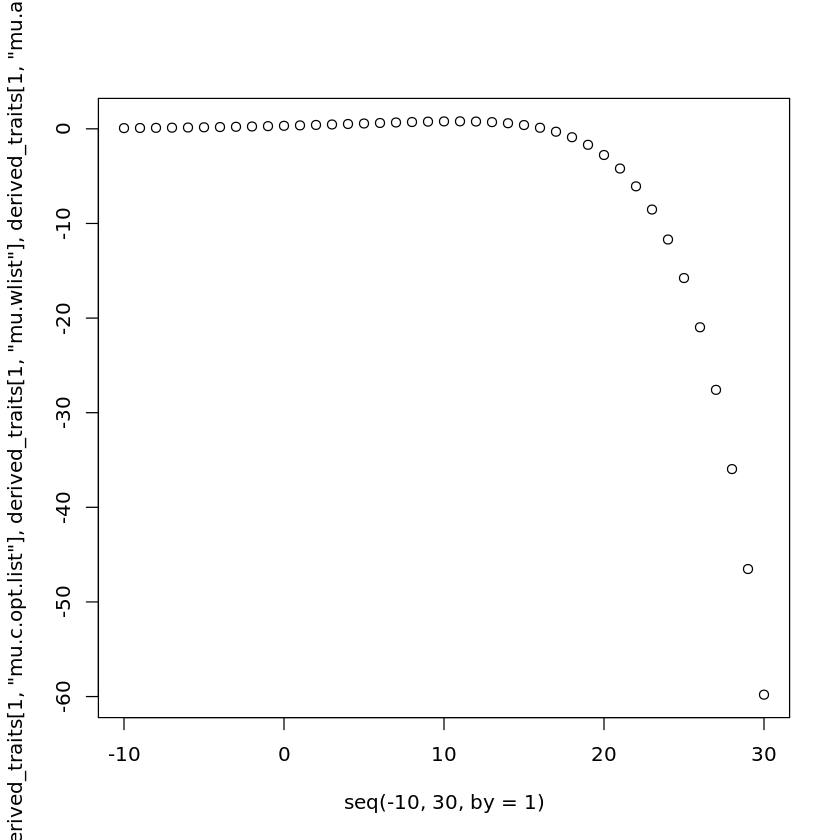

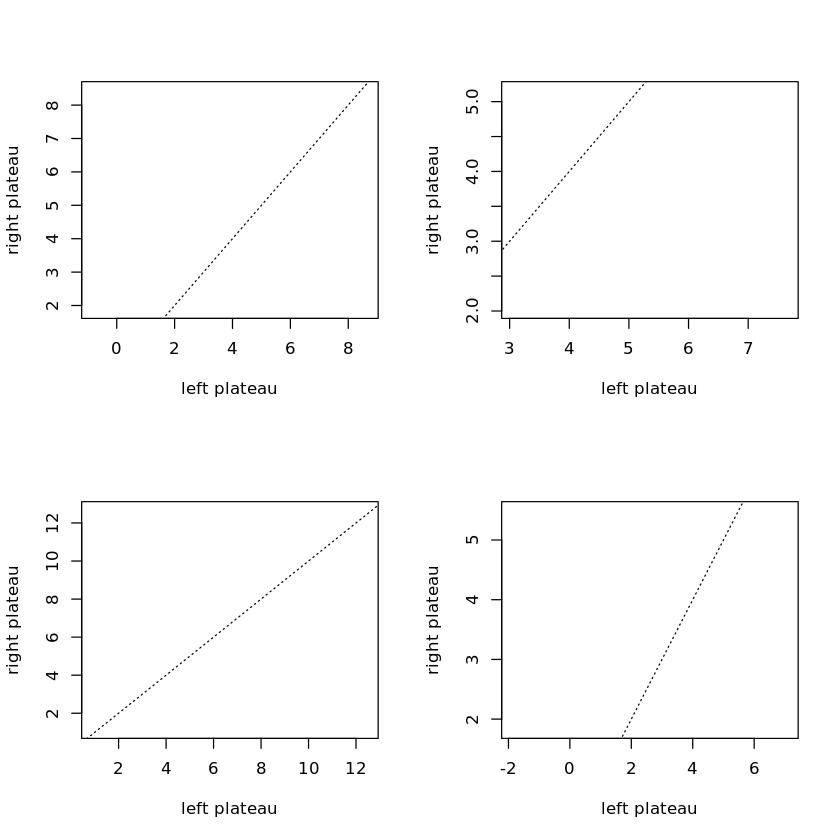

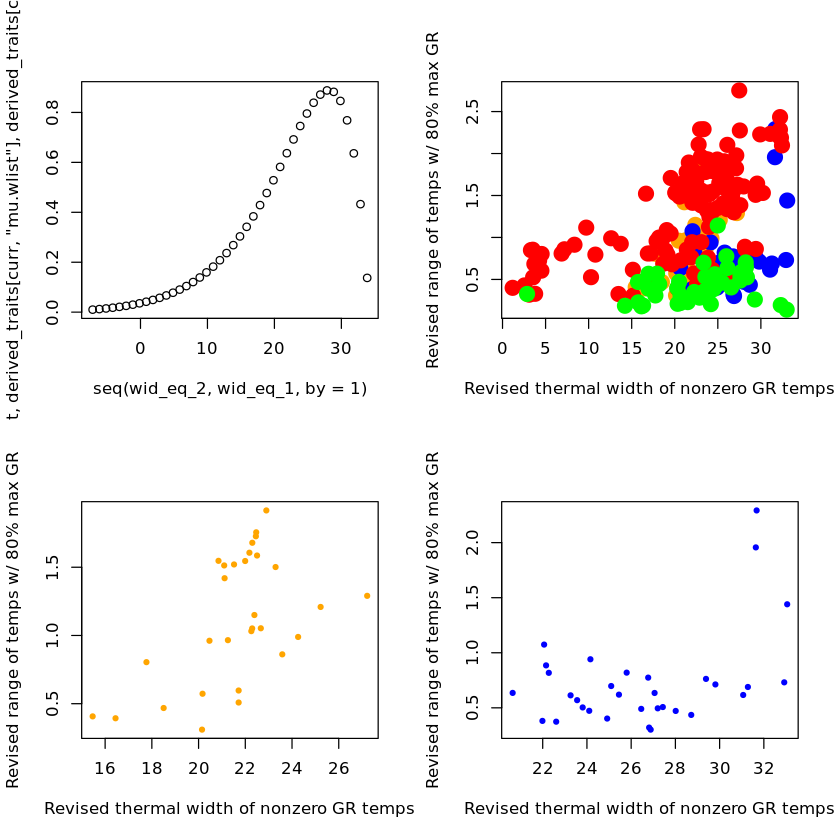

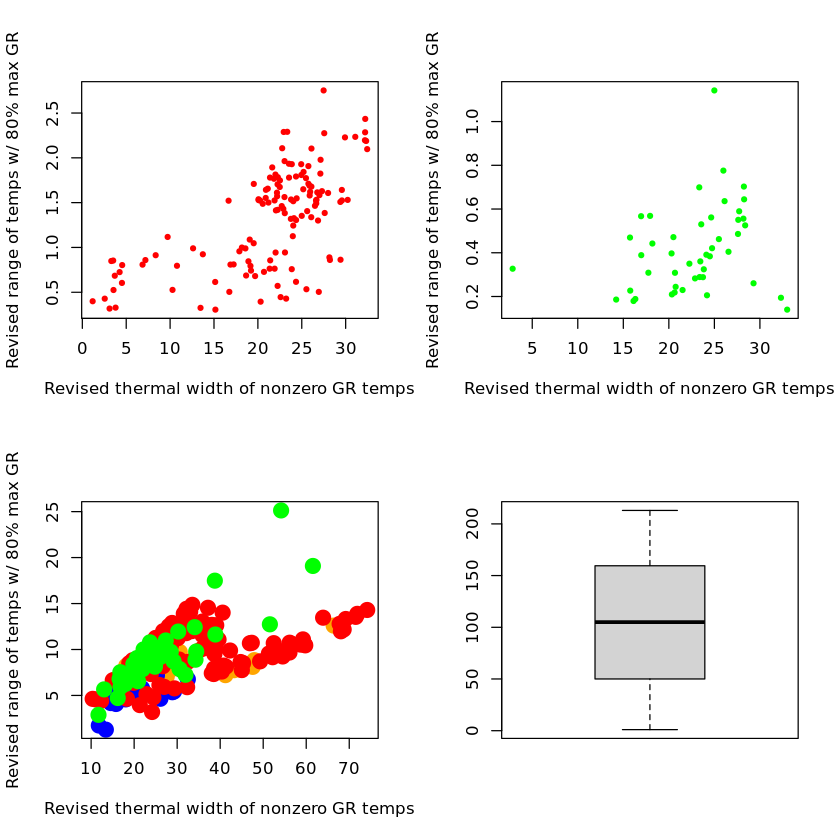


Call:
lm(formula = Revised_plateau ~ Revised_wid, data = revised_df[revised_df$Group == 
    "coccolithophores", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1732 -1.2798  0.0885  1.0149  2.7150 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.13647    0.83147   8.583 2.51e-09 ***
Revised_wid  0.05111    0.02652   1.928   0.0641 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.593 on 28 degrees of freedom
Multiple R-squared:  0.1172,	Adjusted R-squared:  0.08562 
F-statistic: 3.715 on 1 and 28 DF,  p-value: 0.06411



Call:
lm(formula = Revised_plateau ~ Revised_wid, data = revised_df[revised_df$Group == 
    "diatoms", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-6.0550 -1.7141 -0.0884  1.7113  4.8932 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.41803    0.55855  13.281  < 2e-16 ***
Revised_wid  0.07600    0.01468   5.177 8.13e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.371 on 133 degrees of freedom
Multiple R-squared:  0.1677,	Adjusted R-squared:  0.1615 
F-statistic:  26.8 on 1 and 133 DF,  p-value: 8.13e-07



Call:
lm(formula = Revised_plateau ~ Revised_wid, data = revised_df[revised_df$Group == 
    "dinoflagellates", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5064 -0.8348  0.1806  0.9675  7.0813 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.38957    0.80292   1.731   0.0905 .  
Revised_wid  0.30759    0.02884  10.665 8.83e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.956 on 44 degrees of freedom
Multiple R-squared:  0.7211,	Adjusted R-squared:  0.7147 
F-statistic: 113.7 on 1 and 44 DF,  p-value: 8.834e-14


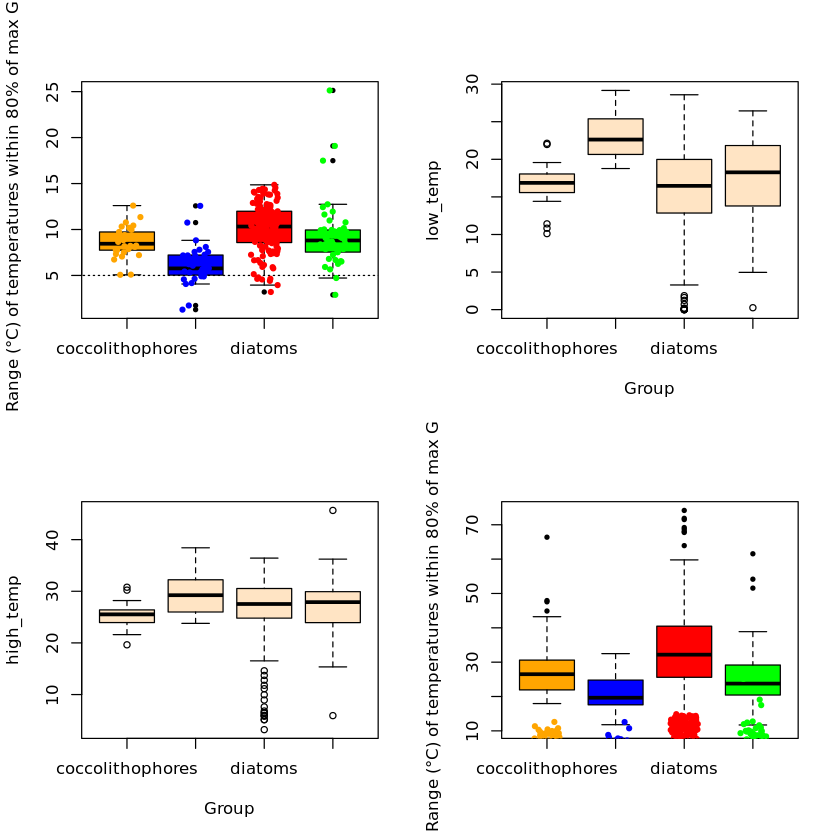

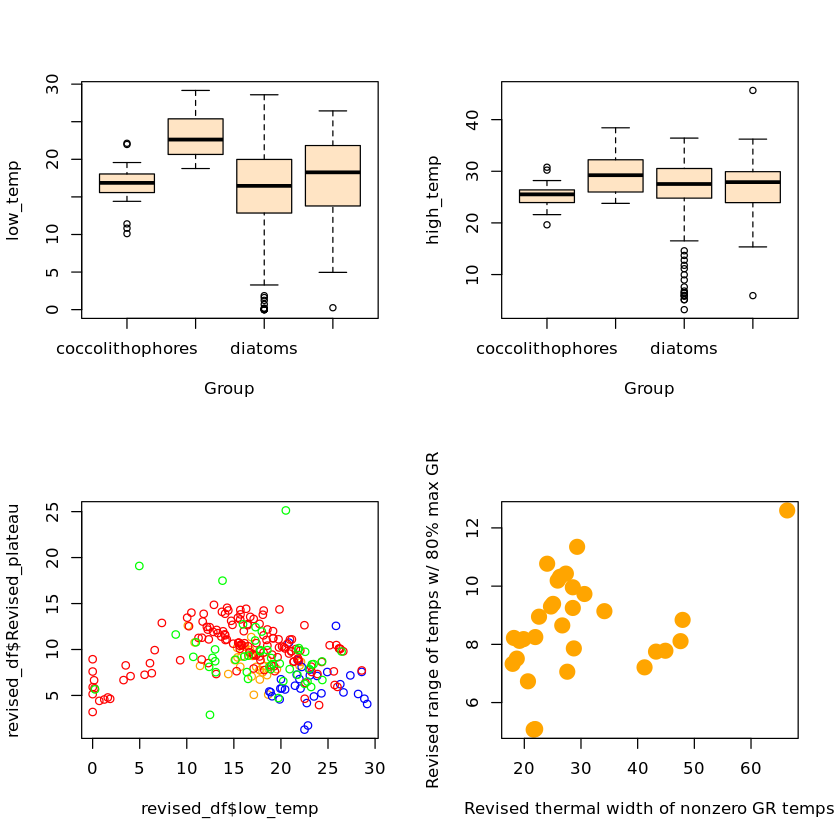

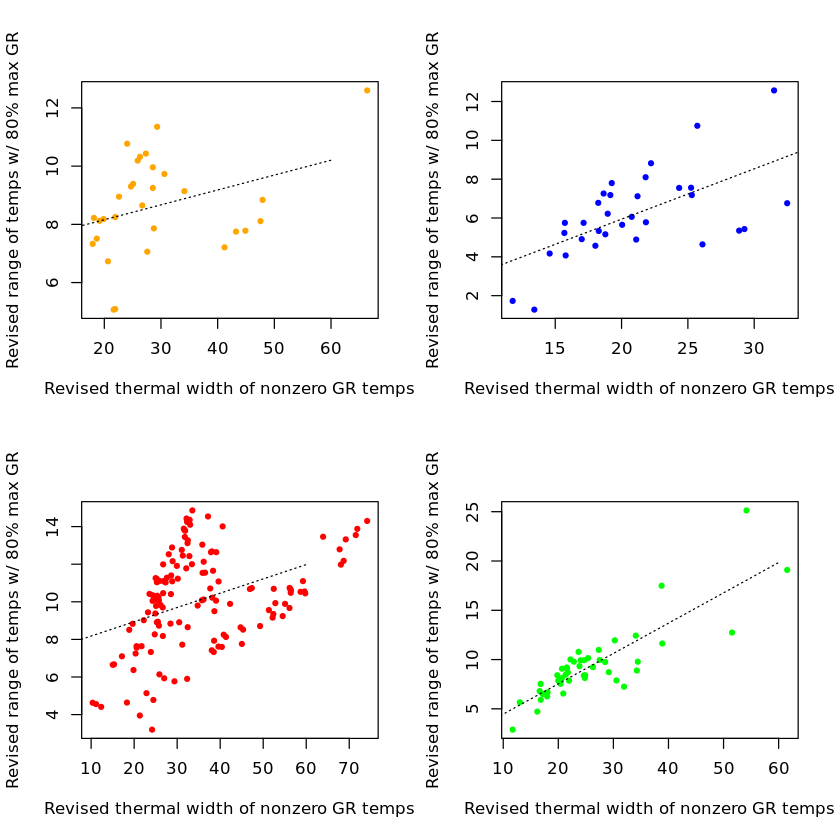

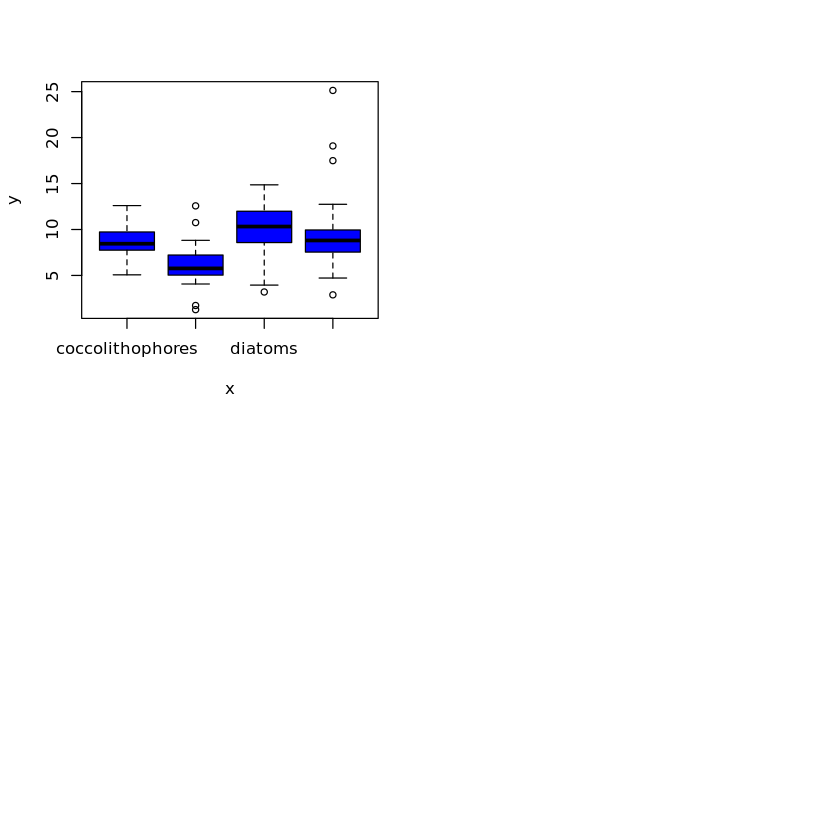

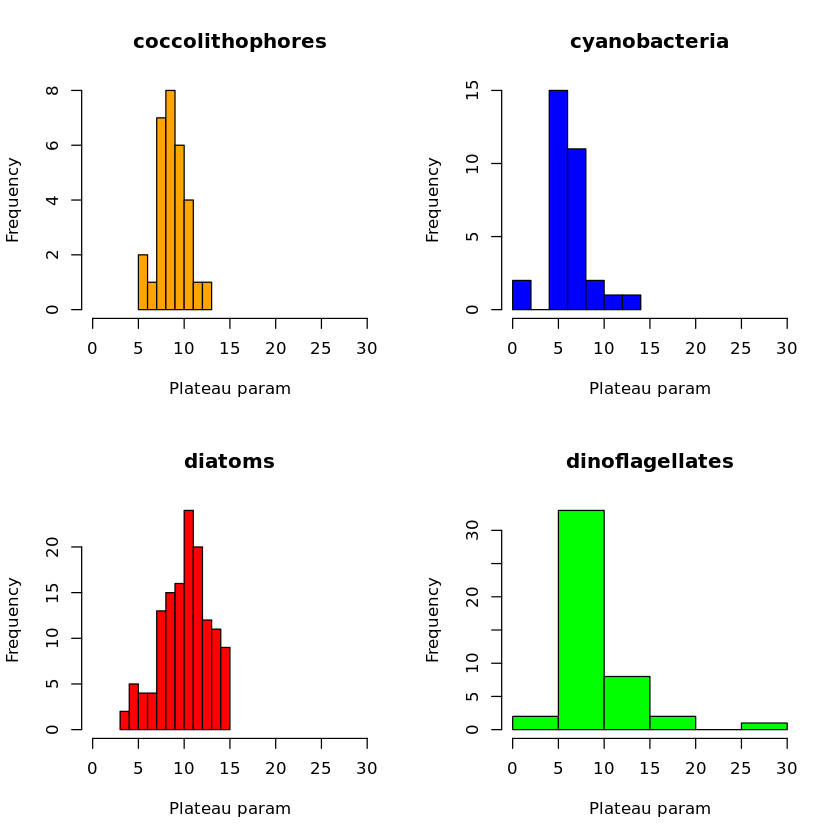

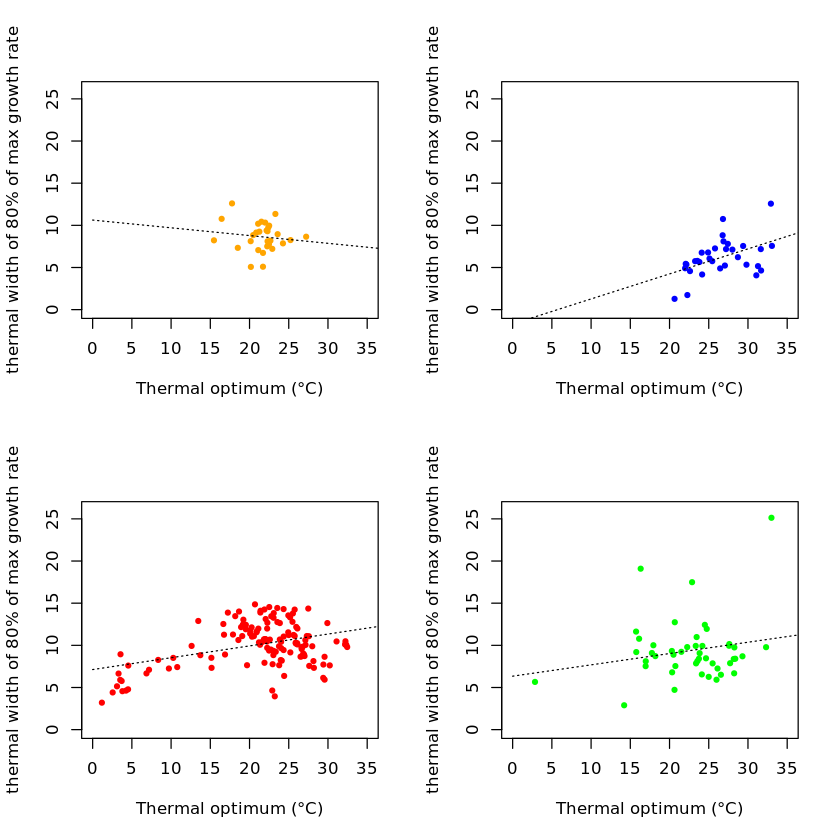

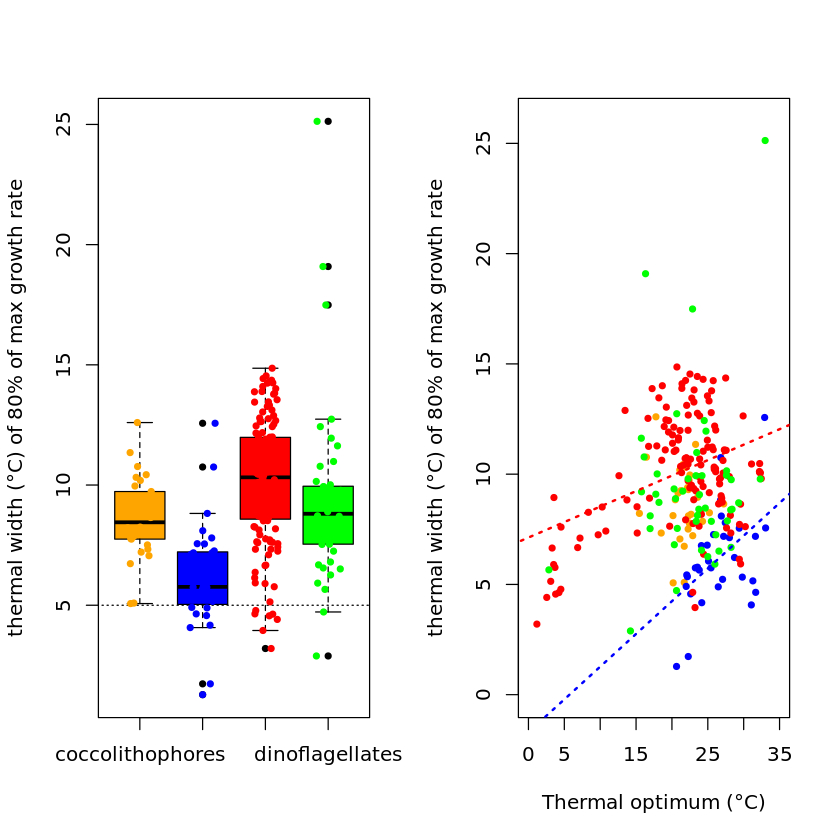

In [2]:
nbcurve <- function(x,opt,w,a,b){
  res<-a*exp(b*x)*(1-((x-opt)/(w/2))^2)
  res
}

derived_traits<-read.csv("../data/PFT_thermal_response/data/derived_traits.csv")
gr_fr<-read.csv("../data/PFT_thermal_response/data/growth_rates.csv")
derived_traits_merge<-merge(derived_traits,gr_fr,by="isolate.code")

plot(seq(-10,30,by=1),nbcurve(seq(-10,30,by=1),
                              derived_traits[1,"mu.c.opt.list"],
                              derived_traits[1,"mu.wlist"],
                              derived_traits[1,"mu.alist"],
                              derived_traits[1,"mu.blist"]))
recalculate=FALSE
revised_df=data.frame()
for (curr in c(1:nrow(derived_traits))) {
  strain_curr=paste(derived_traits[curr,"genus"],
                    derived_traits[curr,"species"],
               derived_traits[curr,"strain"],sep="_")
  group_curr=derived_traits[curr,"group"]
  if (length(group_curr)==0) {
    group_curr="unknown"
  }
  a=derived_traits[curr,"mu.alist"]
  b=derived_traits[curr,"mu.blist"]
  w=derived_traits[curr,"mu.wlist"]
  opt=derived_traits[curr,"mu.c.opt.list"]
  opt_val = optimize(nbcurve,interval=c(-20,40),maximum=TRUE,
                     a=derived_traits[curr,"mu.alist"],
                     b=derived_traits[curr,"mu.blist"],
                     w=derived_traits[curr,"mu.wlist"],
                     opt=opt)$maximum
  if (abs(opt_val) > 100) {
    next # these original parameterizations were bad.
  }
  wid_eq_1 = derived_traits[curr,"mu.wlist"]/2+
    opt
  wid_eq_2 = -derived_traits[curr,"mu.wlist"]/2+
    opt
  tol_gr=0.01 ## we don't want to say the width is valid when GR<this
  test_temp=wid_eq_1
  while ((nbcurve(test_temp,opt,w,a,b) < tol_gr)) {
    test_temp=test_temp+sign(test_temp)*-0.001
  }
  wid_eq_1=test_temp
  test_temp=wid_eq_2
  while ((nbcurve(test_temp,opt,w,a,b) < tol_gr)) {
    test_temp=test_temp+sign(test_temp-wid_eq_1)*-0.001
  }
  wid_eq_2=test_temp
  
  if (recalculate) {
    wid_eq_1 = (derived_traits[curr,"mu.wlist"])/2+
      opt_val
    wid_eq_2 = -(derived_traits[curr,"mu.wlist"])/2+
      opt_val
  }
  tolerance_val=nbcurve(opt_val,opt,w,a,b)*0.8
  temps_test=seq(from = wid_eq_2+sign(wid_eq_2)*wid_eq_2*0.5, 
                 to = wid_eq_1+sign(wid_eq_2)*wid_eq_2*0.5, by = 0.01)
  window_1 = -100
  window_2 = -100
  for (temp in temps_test) {
    if ((window_1<0)&(window_2<0)&(nbcurve(temp,opt,w,a,b) >= tolerance_val)) {
      window_1 = temp
    }else if ((window_2<0)&(window_1>0)&(nbcurve(temp,opt,w,a,b) <= tolerance_val)){
      window_2=temp
    }
  }
  if ((window_1==-100)|(window_2==-100)){
    print("broken")
    break
  }
  if (abs(wid_eq_2-wid_eq_1) > 50) {
    print("broken")
    #break
  }
  revised_df = rbind(revised_df,
                     data.frame(Strain=strain_curr,Revised_opt=opt_val,
                                Group=group_curr,
                                Revised_wid=abs(wid_eq_2-wid_eq_1),
                                Revised_plateau=abs(window_1-window_2),
                                low_temp=window_1,high_temp=window_2,
                                max_GR=nbcurve(opt_val,opt,w,a,b),
                                t_opt=opt_val,a=a,b=b,w=w))
}
revised_df$left_plateau=revised_df$t_opt-revised_df$low_temp
revised_df$right_plateau=revised_df$high_temp-revised_df$t_opt
par(mfrow=c(2,2))
for (group in unique(revised_df$Group)) {
  
  plot(x=revised_df[!is.na(revised_df$right_plateau)&
                      !is.na(revised_df$Strain)&(revised_df$Group==group),"left_plateau"],
       y=revised_df[!is.na(revised_df$right_plateau)&
                      !is.na(revised_df$Strain)&(revised_df$Group==group),"right_plateau"],
       pch=20,cex=3,
       col=revised_df[!is.na(revised_df$right_plateau)&
                        !is.na(revised_df$Strain)&(revised_df$Group==group),"Color"],
       ylab="right plateau",
       xlab="left plateau")
  lines(seq(0,15,by=1),seq(0,15,by=1),lty="dotted")
}

plot(seq(wid_eq_2,wid_eq_1,by=1),nbcurve(seq(wid_eq_2,wid_eq_1,by=1),
                              opt,
                              derived_traits[curr,"mu.wlist"],
                              derived_traits[curr,"mu.alist"],
                              derived_traits[curr,"mu.blist"]))


color_frame=data.frame("Group"=c("diatoms","coccolithophores",
                                 "dinoflagellates","cyanobacteria"),
                       "Color"=c("red","orange","green","blue"))
revised_df=merge(revised_df,color_frame)
plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"t_opt"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"max_GR"],
     pch=20,cex=3,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain),"Color"],
     ylab="Revised range of temps w/ 80% max GR",
     xlab="Revised thermal width of nonzero GR temps")
for (group in unique(revised_df$Group)) {
  plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"t_opt"],
       y=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"max_GR"],
       pch=20,
       col=revised_df[!is.na(revised_df$Revised_plateau)&
                        !is.na(revised_df$Strain)&
                        revised_df$Group==group,"Color"],
       ylab="Revised range of temps w/ 80% max GR",
       xlab="Revised thermal width of nonzero GR temps")
  cocco_model=summary(lm(formula = max_GR~t_opt+t_opt*t_opt,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["Revised_wid","Estimate"]
  lines(seq(0,60,by=1),seq(0,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted")
}

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Revised_wid"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Revised_plateau"],
     pch=20,cex=3,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"Color"],
     ylab="Revised range of temps w/ 80% max GR",
     xlab="Revised thermal width of nonzero GR temps")
boxplot(x=factor(revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Strain"]),
        y=revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Revised_plateau"])
boxplot(Revised_plateau ~ Group, data = revised_df, 
        col = unique(revised_df$Color),pch=20,
        xlab="",ylab="Range (°C) of temperatures within 80% of max GR")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,col=revised_df$Color,pch=20)
boxplot(low_temp ~ Group, data = revised_df, col = "bisque")
boxplot(high_temp ~ Group, data = revised_df, col = "bisque")

boxplot(Revised_wid ~ Group, data = revised_df, 
        col = unique(revised_df$Color),pch=20,
        xlab="",ylab="Range (°C) of temperatures within 80% of max GR")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,col=revised_df$Color,pch=20)
boxplot(low_temp ~ Group, data = revised_df, col = "bisque")
boxplot(high_temp ~ Group, data = revised_df, col = "bisque")

summary(lm(formula = Revised_plateau~Revised_wid,
   data = revised_df[revised_df$Group=="coccolithophores",]))
summary(lm(formula = Revised_plateau~Revised_wid,
           data = revised_df[revised_df$Group=="diatoms",]))
summary(lm(formula = Revised_plateau~Revised_wid,
           data = revised_df[revised_df$Group=="dinoflagellates",]))
plot(x=revised_df$low_temp,y=revised_df$Revised_plateau,
     col=revised_df$Color)

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain)&
                    (revised_df$Group=="coccolithophores"),"Revised_wid"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain)&
                    (revised_df$Group=="coccolithophores"),"Revised_plateau"],
     pch=20,cex=3,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain)&
                    (revised_df$Group=="coccolithophores"),"Color"],
     ylab="Revised range of temps w/ 80% max GR",
     xlab="Revised thermal width of nonzero GR temps")


for (group in unique(revised_df$Group)) {
  plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"Revised_wid"],
       y=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"Revised_plateau"],
       pch=20,
       col=revised_df[!is.na(revised_df$Revised_plateau)&
                        !is.na(revised_df$Strain)&
                        revised_df$Group==group,"Color"],
       ylab="Revised range of temps w/ 80% max GR",
       xlab="Revised thermal width of nonzero GR temps")
  cocco_model=summary(lm(formula = Revised_plateau~Revised_wid,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["Revised_wid","Estimate"]
  lines(seq(0,60,by=1),seq(0,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted")
}

plot(y=as.numeric(revised_df$Revised_plateau),x=factor(revised_df$Group),
        col="blue")
par(mfrow=c(2,2))
for (group in unique(revised_df$Group)) {
  hist(x=revised_df[revised_df$Group==group,"Revised_plateau"],
       col =revised_df[revised_df$Group==group,"Color"],xlab="Plateau param",
       main=group,xlim=c(0,30))

}

par(mfrow=c(2,2))
for (group in unique(revised_df$Group)) {
  plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"t_opt"],
       y=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"Revised_plateau"],
       pch=20,
       col=revised_df[!is.na(revised_df$Revised_plateau)&
                        !is.na(revised_df$Strain)&
                        revised_df$Group==group,"Color"],
       ylab="thermal width of 80% of max growth rate",
       xlab="Thermal optimum (°C)",ylim=c(0,26),xlim=c(0,35))
  dev.hold()
  cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["t_opt","Estimate"]
  lines(seq(0,60,by=1),seq(0,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted")
}
par(mfrow=c(1,2))

boxplot(Revised_plateau ~ Group, data = revised_df, 
        col = unique(revised_df$Color),pch=20,
        xlab="",ylab="thermal width (°C) of 80% of max growth rate")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,col=revised_df$Color,pch=20)

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"t_opt"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"Revised_plateau"],
     pch=20,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain),"Color"],
     ylab="thermal width (°C) of 80% of max growth rate",
     xlab="Thermal optimum (°C)",ylim=c(0,26),xlim=c(0,35))
for (group in c("diatoms","cyanobacteria")) {#unique(revised_df$Group)) {
  dev.hold()
  cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["t_opt","Estimate"]
  lines(seq(-10,60,by=1),seq(-10,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted",col=unique(revised_df[revised_df$Group==group,"Color"]),
        lwd=2)
}
cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                       data = revised_df))


In [3]:
derived_traits

isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,⋯,mu.blist,mu.c.opt.list,mu.c.opt.val.list,mu.g.opt.list,mu.g.opt.val.list,mu.n,tmin,tmax,minqual,maxqual
<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
7,"Southern Ocean, Indian sector",-58.00,62.00,marine,Chaetoceros deflandrei,Chaetoceros deflandrei,,,,⋯,0.16049225,-11.051954,0.06581866,10.784289,0.7955202,19,-38.4184582,16.314550,bad,good
8,"Southern Ocean, Indian sector",-58.00,62.00,marine,Corethron pennatum,Corethron pennatum,Corethron criophilum,,,⋯,0.22854161,-11.175168,0.03202718,3.104547,0.3181307,10,-29.3101606,6.959824,bad,good
9,"Southern Ocean, Indian sector",-58.00,62.00,marine,Fragilariopsis cylindrus,Fragilariopsis cylindrus,Nitzschia cylindrus,,,⋯,0.15410494,-20.047895,0.05257042,4.541612,0.8032224,12,-50.4414011,10.345611,bad,good
10,"Southern Ocean, Indian sector",-58.00,62.00,marine,Fragilariopsis kerguelensis,Fragilariopsis kerguelensis,Nitzschia kerguelensis,,,⋯,0.20933183,-15.371633,0.03786553,3.698049,0.6844997,10,-38.7351242,7.991859,bad,good
11,"Southern Ocean, Indian sector",-58.00,62.00,marine,Pseudo-nitzschia turgiduloides,Pseudo-nitzschia turgiduloides,Nitzschia turgiduloides,,,⋯,0.02939634,3.850833,0.72049796,4.248702,0.7247321,12,-1.3647251,9.066391,good,good
12,"Southern Ocean, Indian sector",-58.00,62.00,marine,Stellarima microtrias,Stellarima microtrias,,,,⋯,0.20053115,-18.777566,0.03161620,3.514375,0.8539217,8,-45.5966146,8.041483,bad,good
13,"Southern Ocean, Indian sector",-58.00,62.00,marine,Synedra sp.,Synedra,,,,⋯,0.26303276,-19.401928,0.00464179,4.514880,0.6042542,8,-46.8585955,8.054739,bad,good
14,"Big Glory Bay, New Zealand",-46.98,168.12,marine,Emiliania huxleyi,Emiliania huxleyi,Coccolithus huxleyi,,,⋯,0.05727726,20.005894,0.97287079,22.663903,1.0527312,5,10.0112530,30.000534,good,good
15,West New Zealand,-42.18,169.50,marine,Emiliania huxleyi R strain TQ26,Emiliania huxleyi,Coccolithus huxleyi,,R strain TQ26,⋯,0.14093529,12.372606,0.66914880,21.114383,1.4194354,6,-1.7855891,26.530800,bad,good


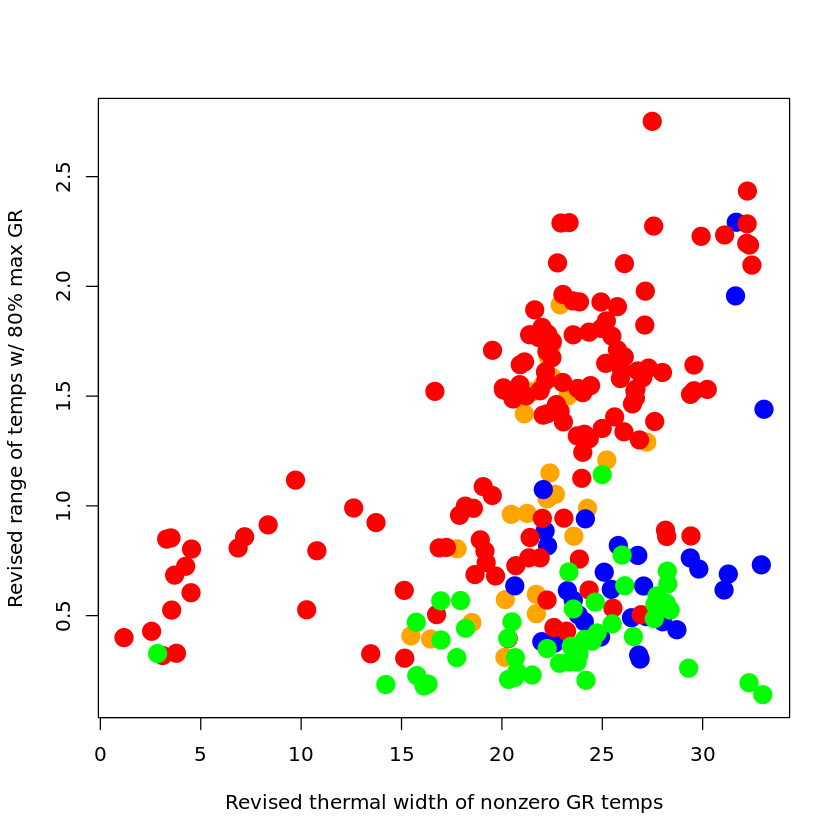

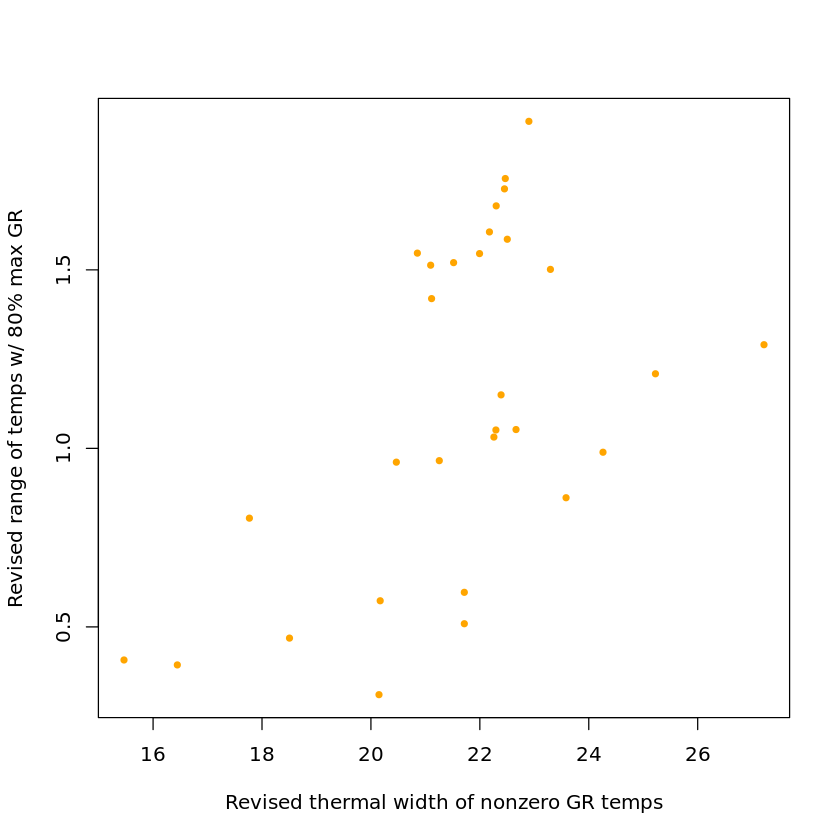

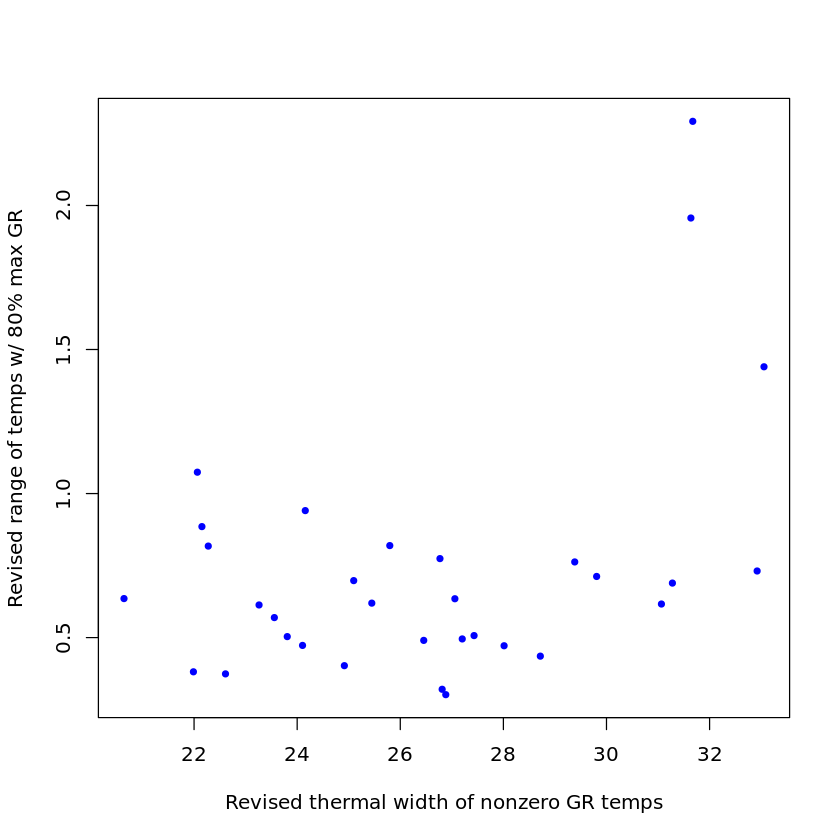

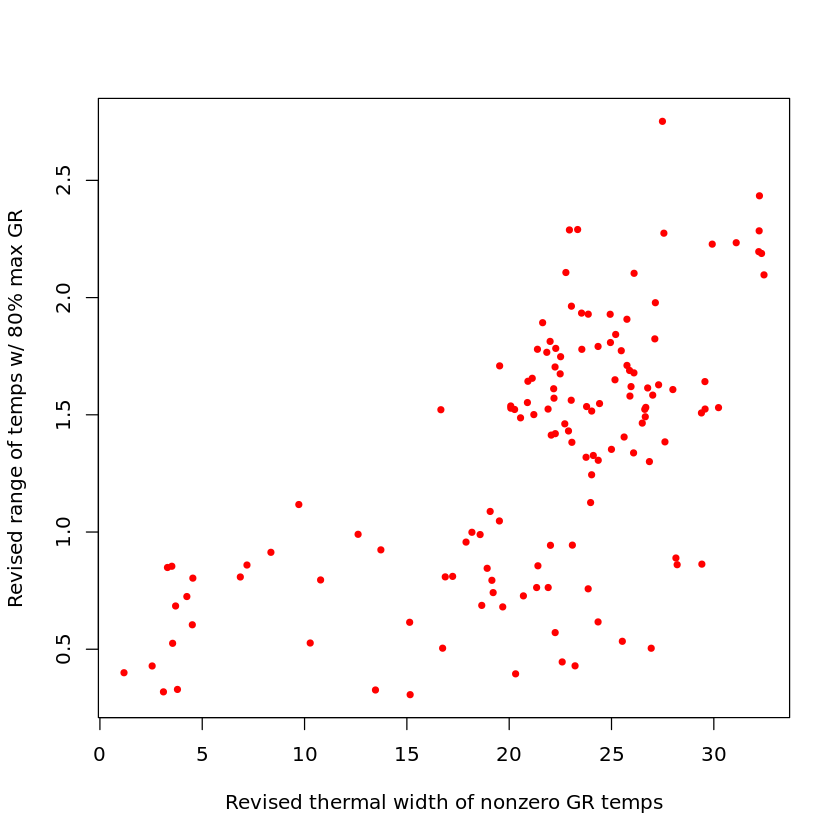

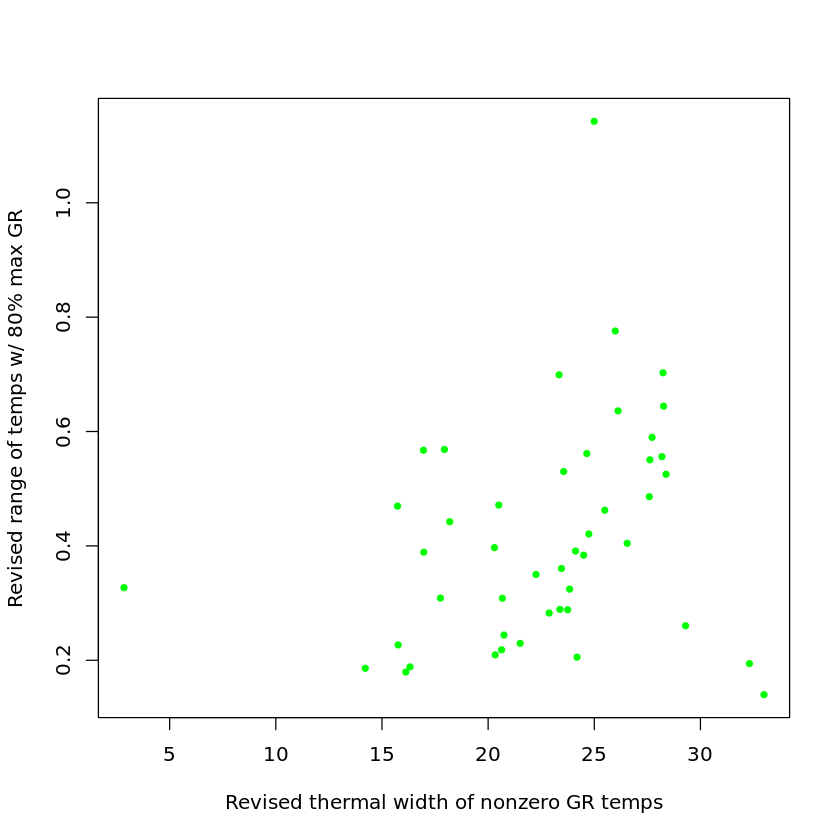

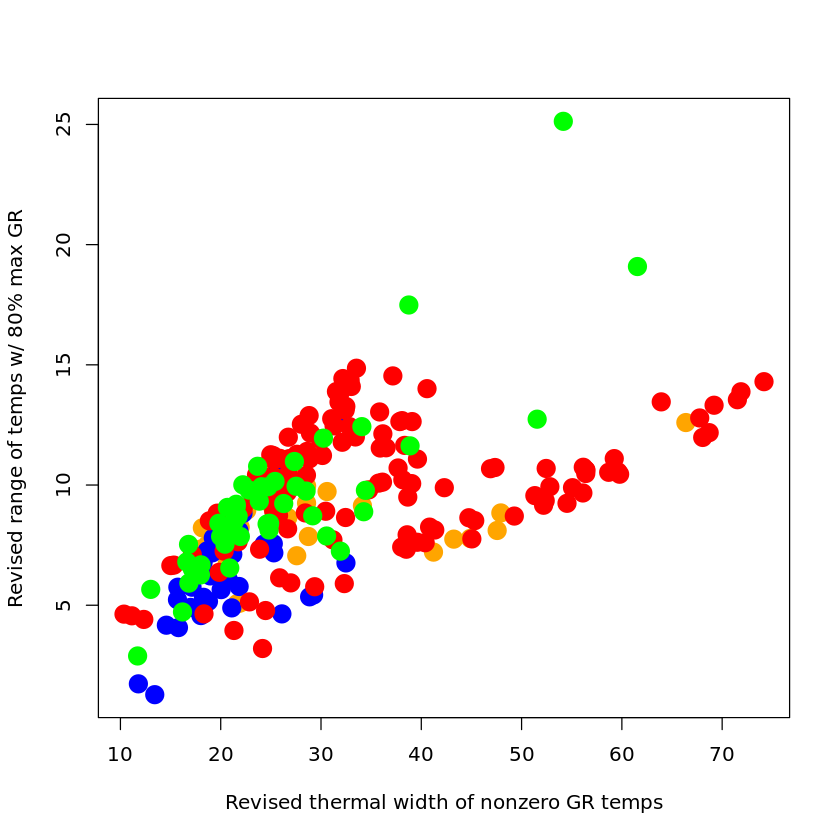

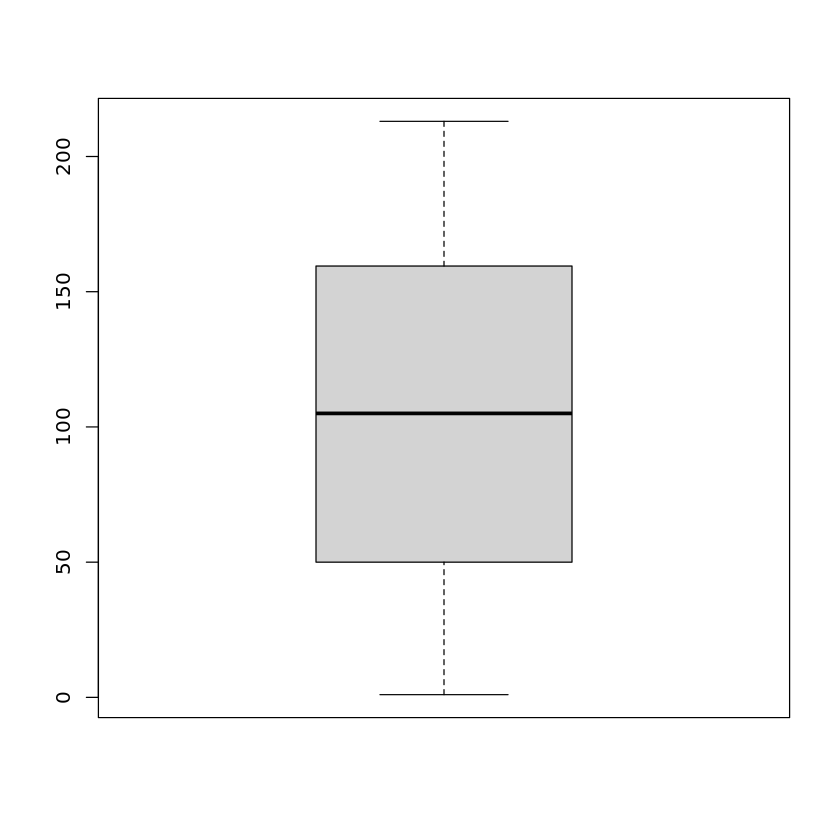

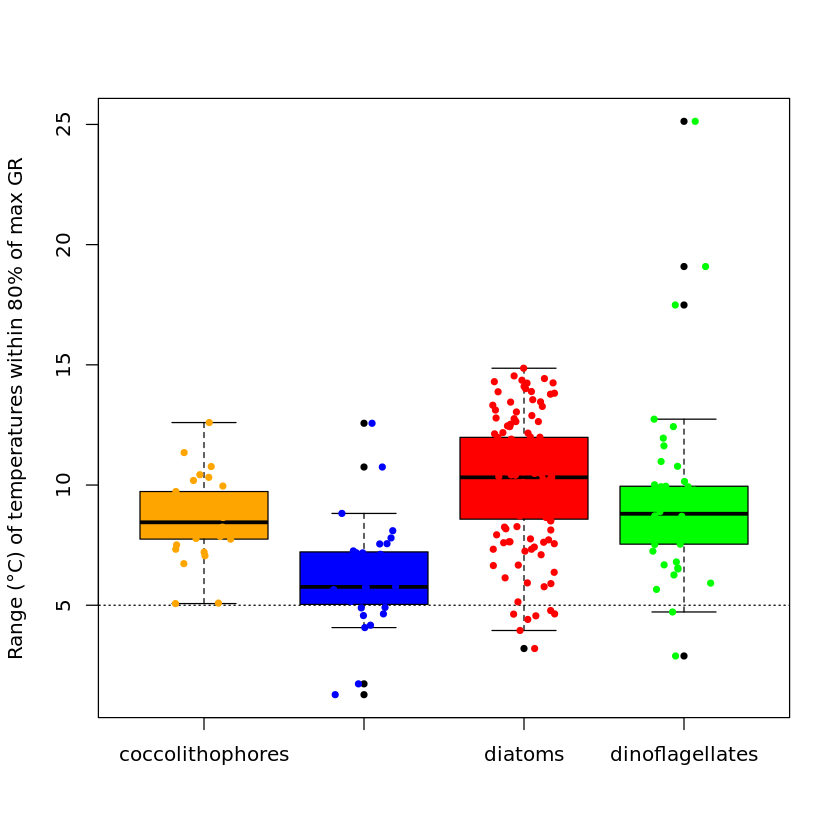

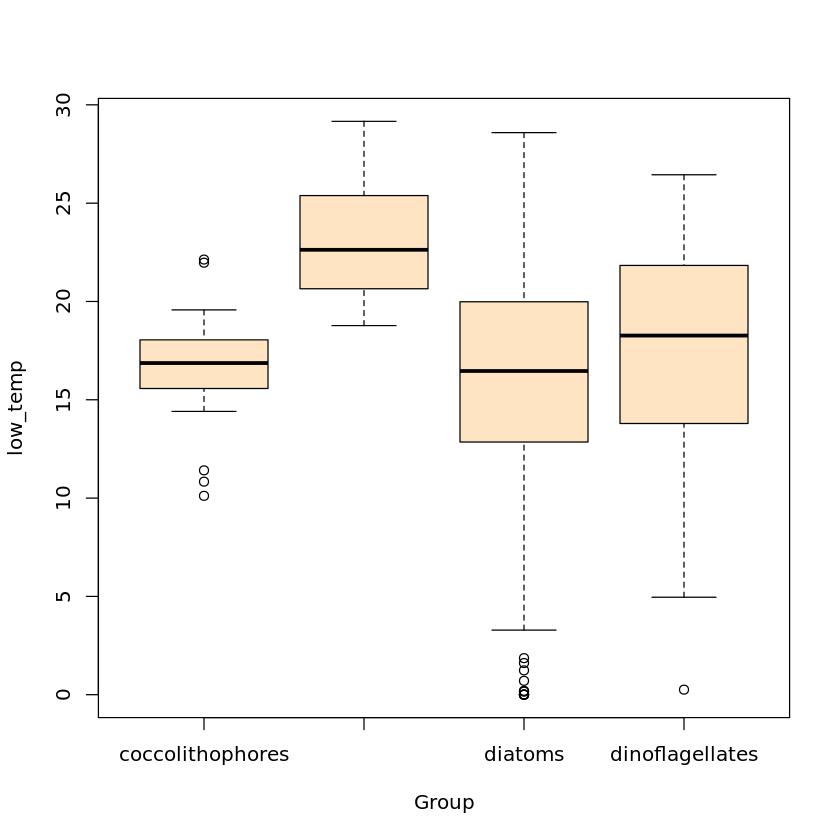

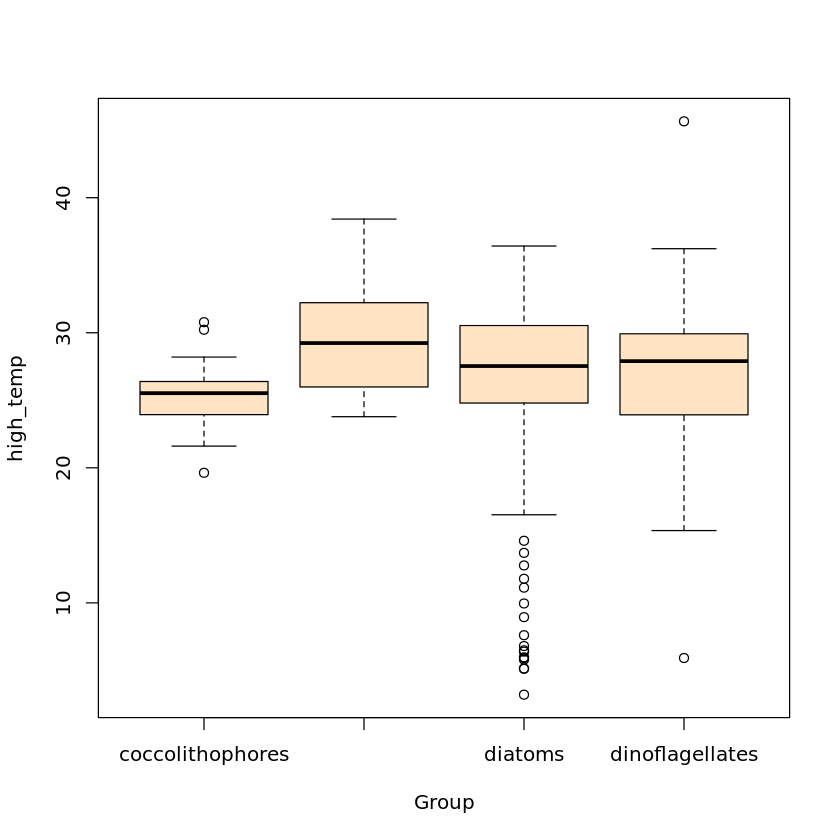

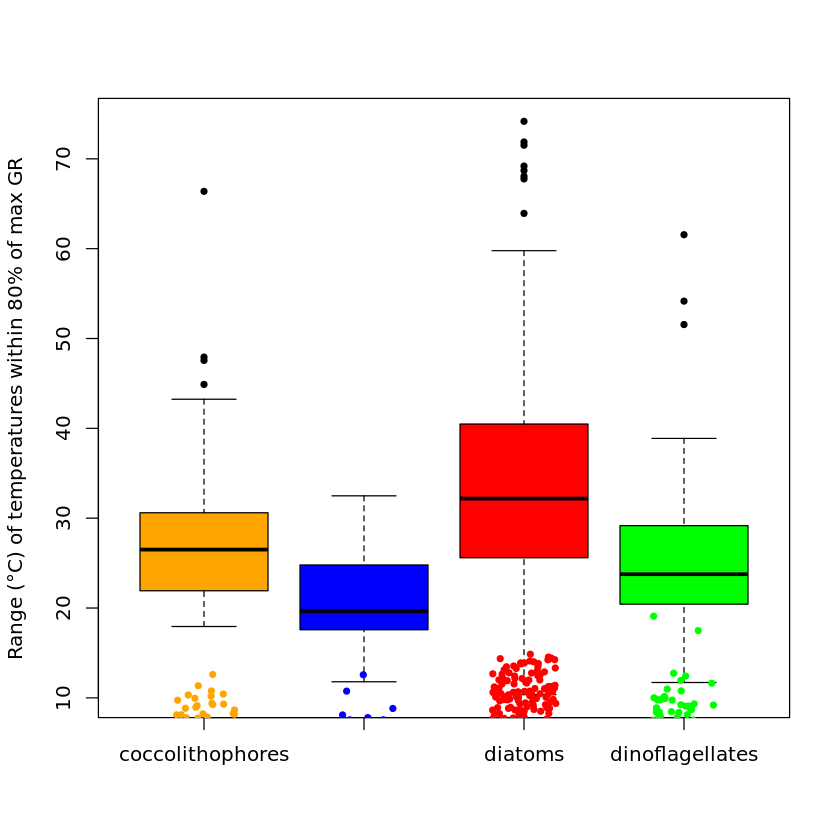

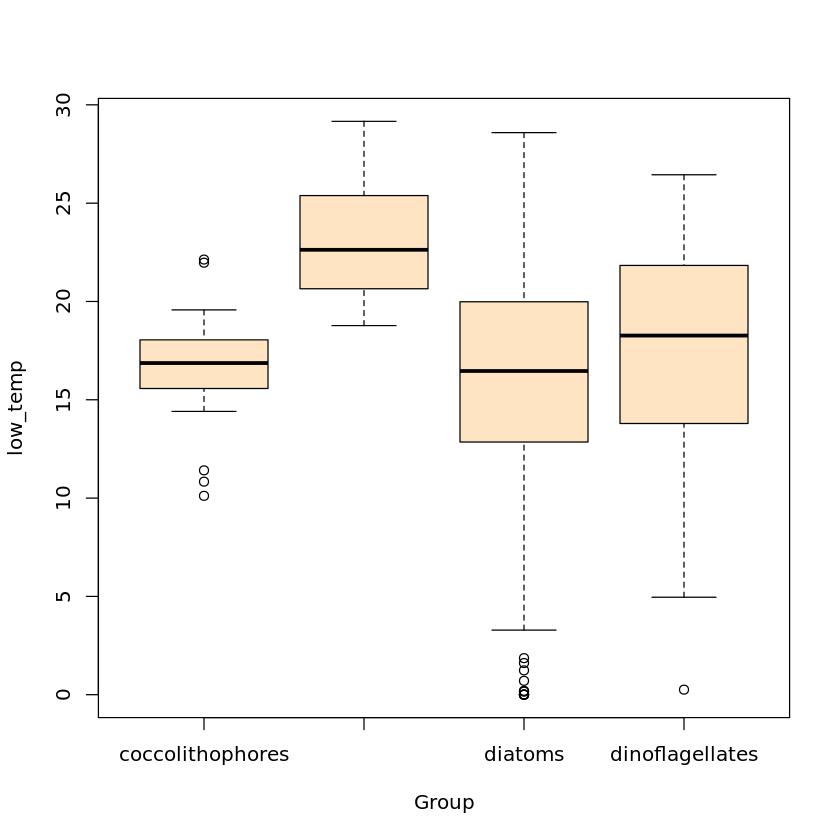


Call:
lm(formula = Revised_plateau ~ Revised_wid, data = revised_df[revised_df$Group == 
    "coccolithophores", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1732 -1.2798  0.0885  1.0149  2.7150 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.13647    0.83147   8.583 2.51e-09 ***
Revised_wid  0.05111    0.02652   1.928   0.0641 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.593 on 28 degrees of freedom
Multiple R-squared:  0.1172,	Adjusted R-squared:  0.08562 
F-statistic: 3.715 on 1 and 28 DF,  p-value: 0.06411



Call:
lm(formula = Revised_plateau ~ Revised_wid, data = revised_df[revised_df$Group == 
    "diatoms", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-6.0550 -1.7141 -0.0884  1.7113  4.8932 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.41803    0.55855  13.281  < 2e-16 ***
Revised_wid  0.07600    0.01468   5.177 8.13e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.371 on 133 degrees of freedom
Multiple R-squared:  0.1677,	Adjusted R-squared:  0.1615 
F-statistic:  26.8 on 1 and 133 DF,  p-value: 8.13e-07



Call:
lm(formula = Revised_plateau ~ Revised_wid, data = revised_df[revised_df$Group == 
    "dinoflagellates", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5064 -0.8348  0.1806  0.9675  7.0813 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.38957    0.80292   1.731   0.0905 .  
Revised_wid  0.30759    0.02884  10.665 8.83e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.956 on 44 degrees of freedom
Multiple R-squared:  0.7211,	Adjusted R-squared:  0.7147 
F-statistic: 113.7 on 1 and 44 DF,  p-value: 8.834e-14


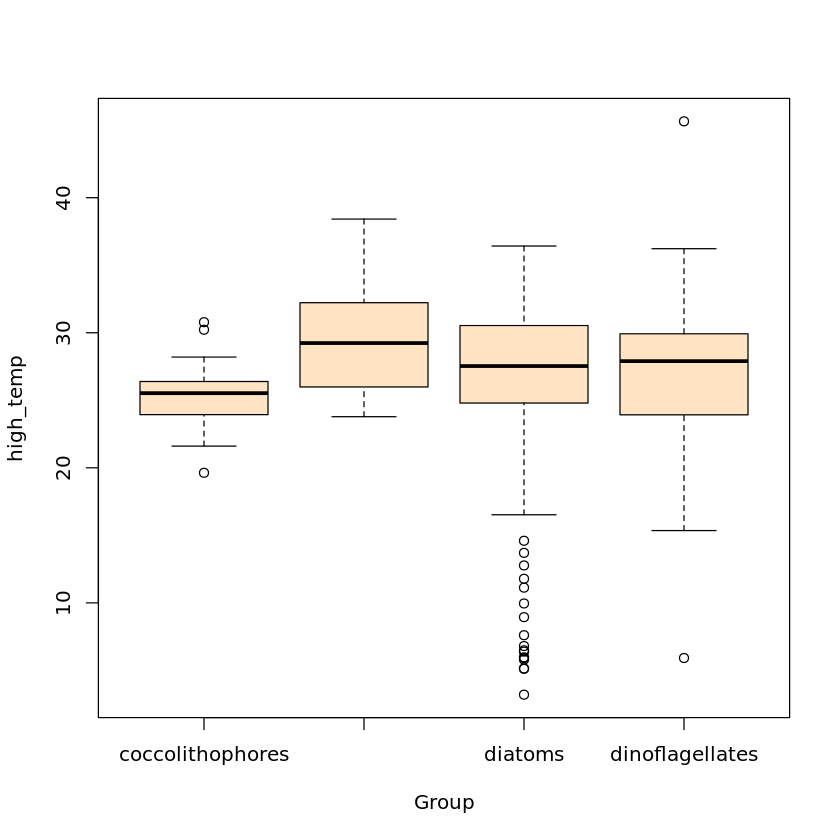

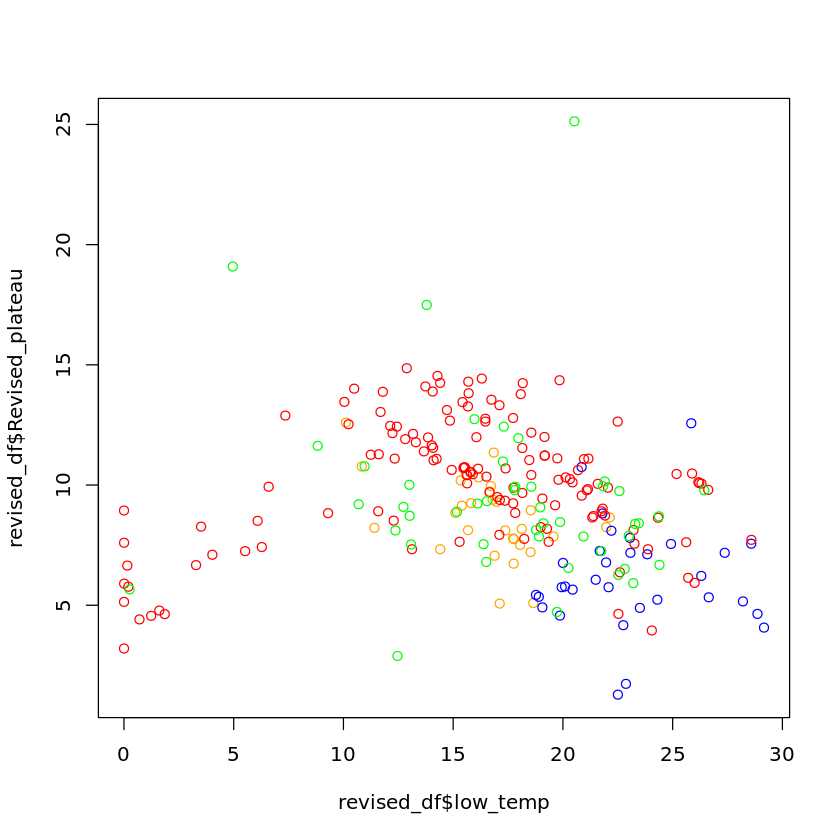

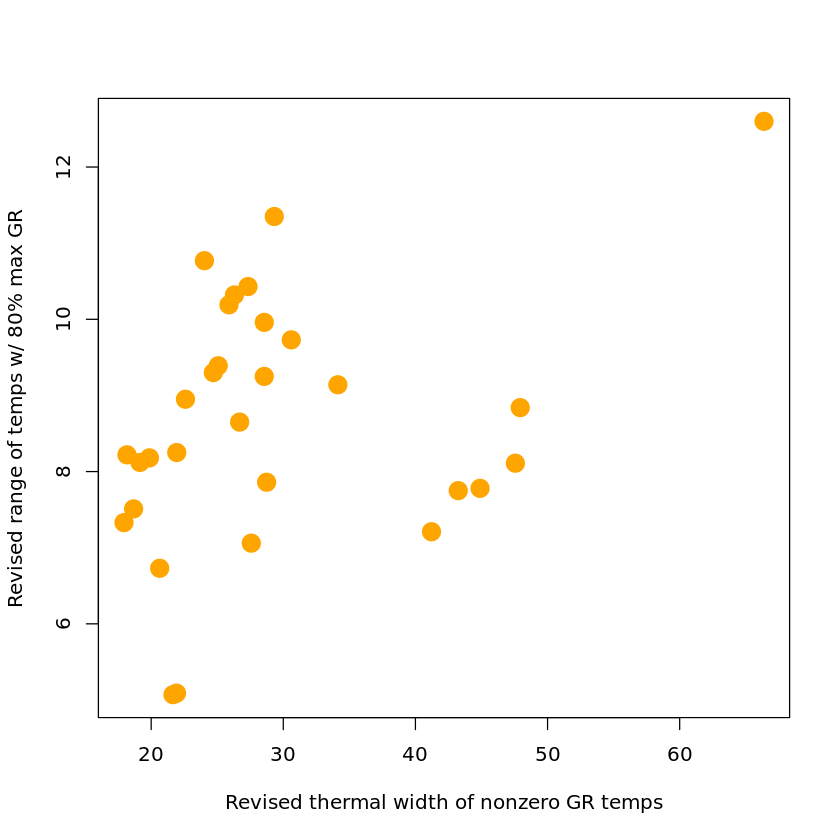

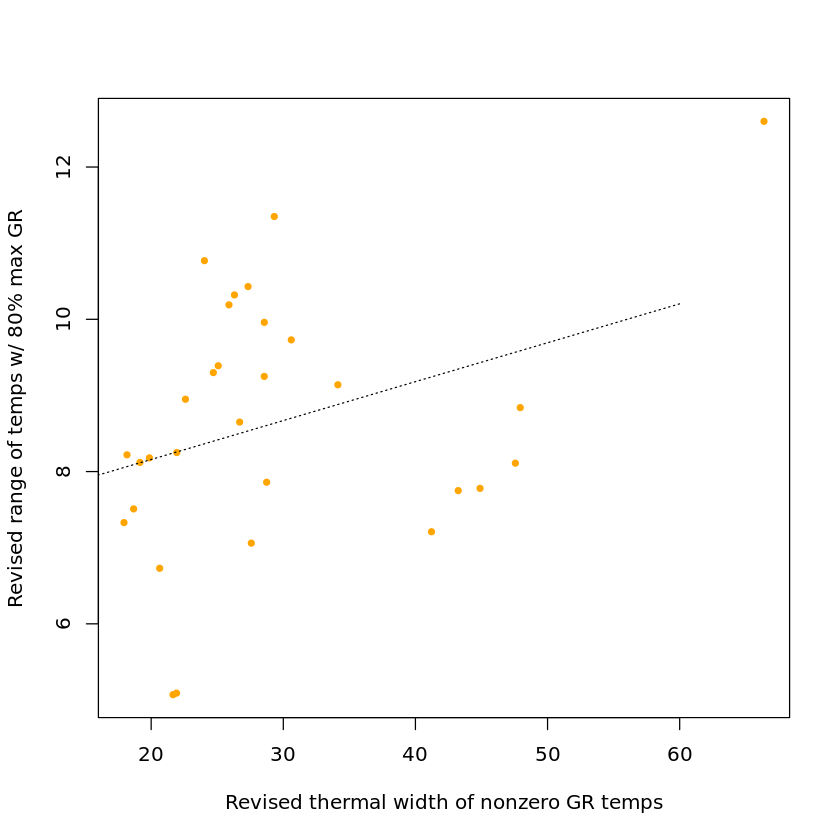

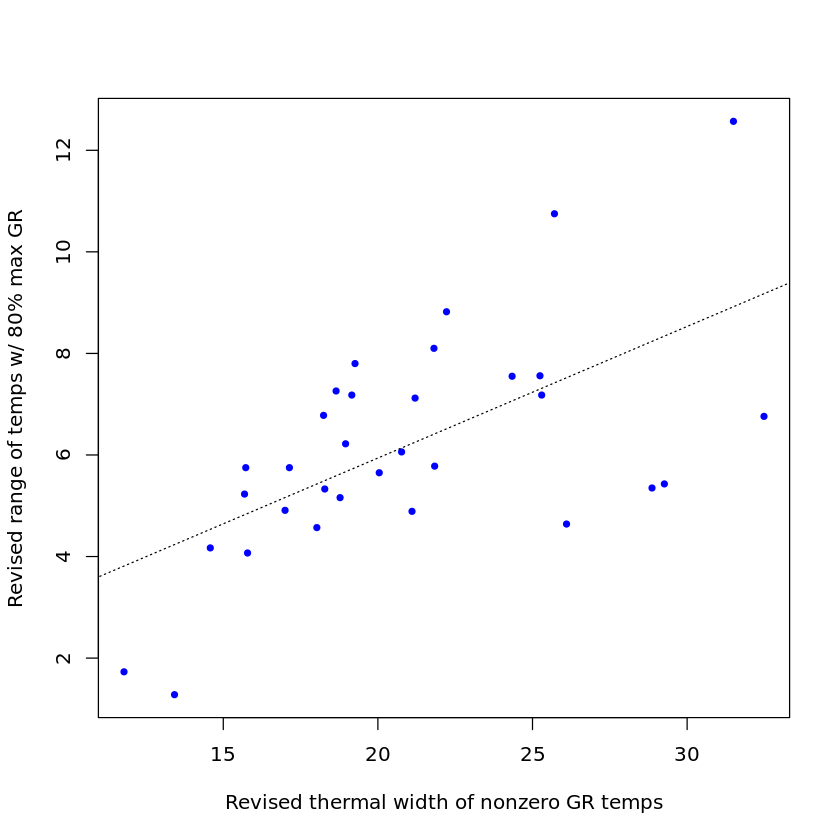

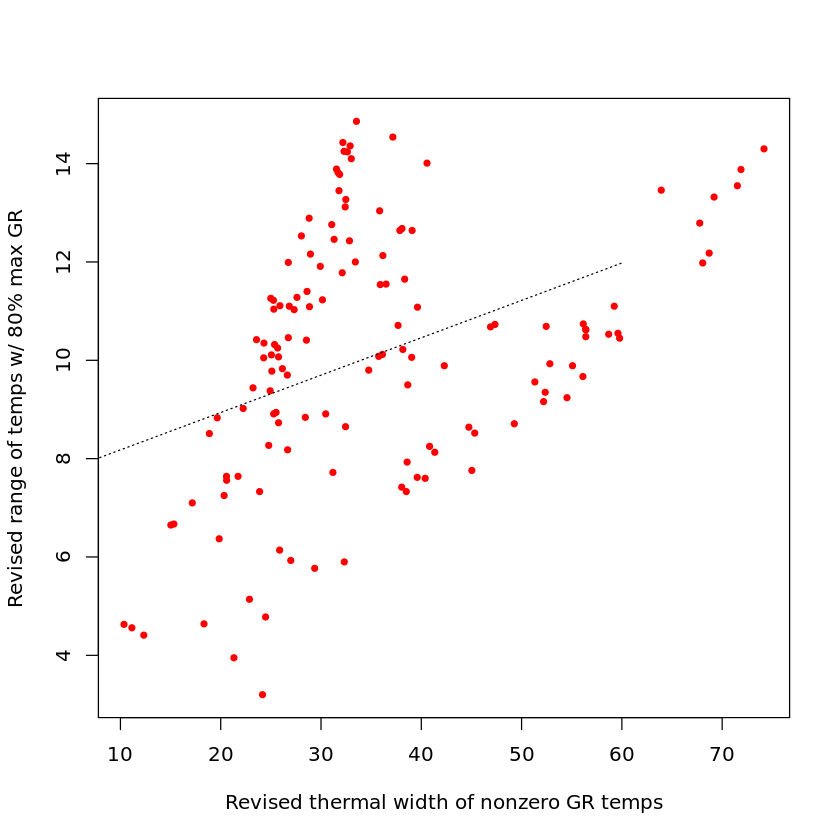

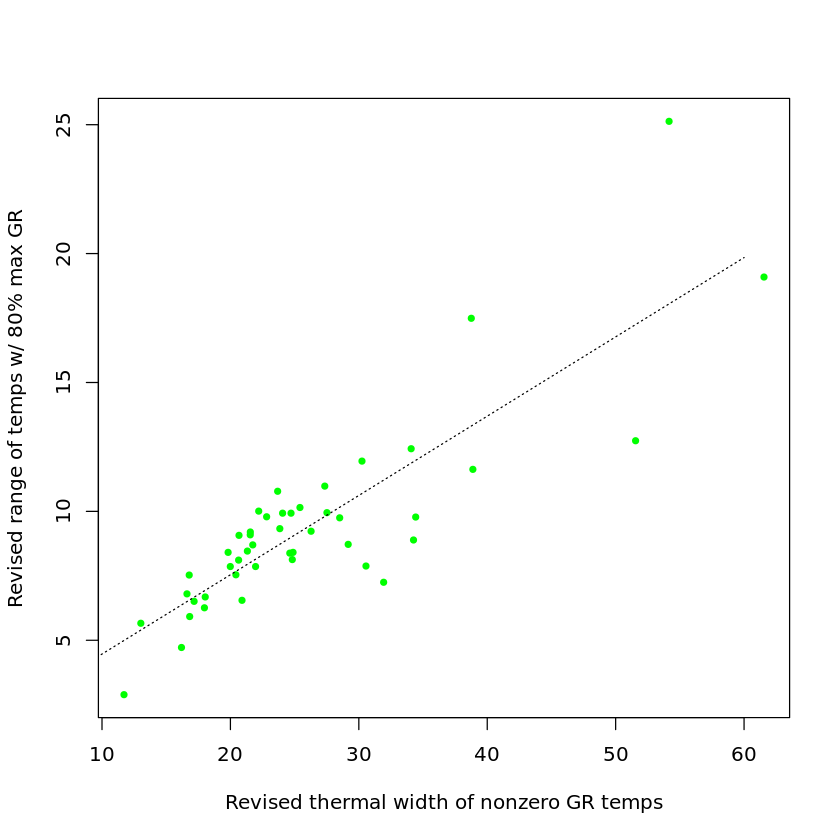

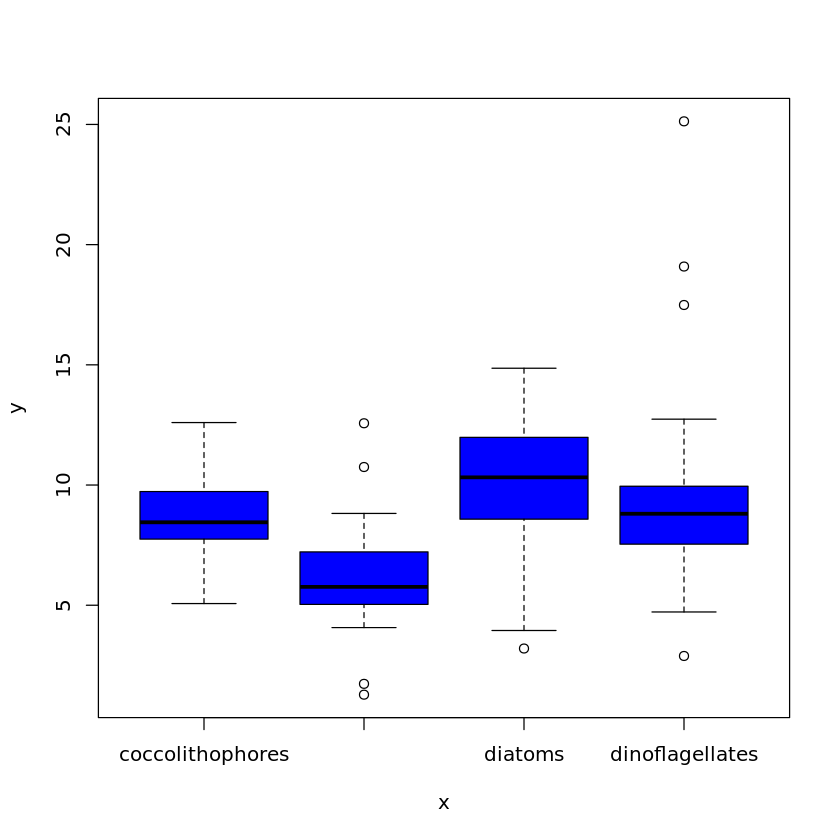

ERROR: Error in mfrow(c(2, 2)): could not find function "mfrow"


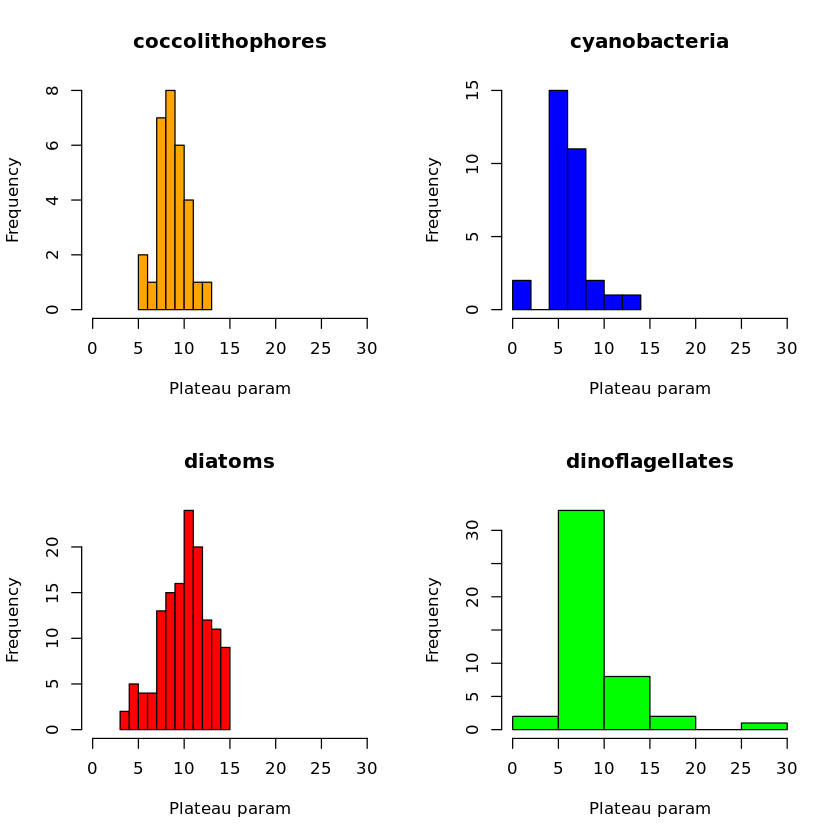

In [4]:

color_frame=data.frame("Group"=c("diatoms","coccolithophores",
                                 "dinoflagellates","cyanobacteria"),
                       "Color"=c("red","orange","green","blue"))
revised_df=merge(revised_df,color_frame)
plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"t_opt"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"max_GR"],
     pch=20,cex=3,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain),"Color"],
     ylab="Revised range of temps w/ 80% max GR",
     xlab="Revised thermal width of nonzero GR temps")
for (group in unique(revised_df$Group)) {
  plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"t_opt"],
       y=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"max_GR"],
       pch=20,
       col=revised_df[!is.na(revised_df$Revised_plateau)&
                        !is.na(revised_df$Strain)&
                        revised_df$Group==group,"Color"],
       ylab="Revised range of temps w/ 80% max GR",
       xlab="Revised thermal width of nonzero GR temps")
  cocco_model=summary(lm(formula = max_GR~t_opt+t_opt*t_opt,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["Revised_wid","Estimate"]
  lines(seq(0,60,by=1),seq(0,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted")
}

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Revised_wid"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Revised_plateau"],
     pch=20,cex=3,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"Color"],
     ylab="Revised range of temps w/ 80% max GR",
     xlab="Revised thermal width of nonzero GR temps")
boxplot(x=factor(revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Strain"]),
        y=revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Revised_plateau"])
boxplot(Revised_plateau ~ Group, data = revised_df, 
        col = unique(revised_df$Color),pch=20,
        xlab="",ylab="Range (°C) of temperatures within 80% of max GR")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,col=revised_df$Color,pch=20)
boxplot(low_temp ~ Group, data = revised_df, col = "bisque")
boxplot(high_temp ~ Group, data = revised_df, col = "bisque")

boxplot(Revised_wid ~ Group, data = revised_df, 
        col = unique(revised_df$Color),pch=20,
        xlab="",ylab="Range (°C) of temperatures within 80% of max GR")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,col=revised_df$Color,pch=20)
boxplot(low_temp ~ Group, data = revised_df, col = "bisque")
boxplot(high_temp ~ Group, data = revised_df, col = "bisque")

summary(lm(formula = Revised_plateau~Revised_wid,
   data = revised_df[revised_df$Group=="coccolithophores",]))
summary(lm(formula = Revised_plateau~Revised_wid,
           data = revised_df[revised_df$Group=="diatoms",]))
summary(lm(formula = Revised_plateau~Revised_wid,
           data = revised_df[revised_df$Group=="dinoflagellates",]))
plot(x=revised_df$low_temp,y=revised_df$Revised_plateau,
     col=revised_df$Color)

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain)&
                    (revised_df$Group=="coccolithophores"),"Revised_wid"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain)&
                    (revised_df$Group=="coccolithophores"),"Revised_plateau"],
     pch=20,cex=3,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain)&
                    (revised_df$Group=="coccolithophores"),"Color"],
     ylab="Revised range of temps w/ 80% max GR",
     xlab="Revised thermal width of nonzero GR temps")


for (group in unique(revised_df$Group)) {
  plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"Revised_wid"],
       y=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"Revised_plateau"],
       pch=20,
       col=revised_df[!is.na(revised_df$Revised_plateau)&
                        !is.na(revised_df$Strain)&
                        revised_df$Group==group,"Color"],
       ylab="Revised range of temps w/ 80% max GR",
       xlab="Revised thermal width of nonzero GR temps")
  cocco_model=summary(lm(formula = Revised_plateau~Revised_wid,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["Revised_wid","Estimate"]
  lines(seq(0,60,by=1),seq(0,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted")
}

plot(y=as.numeric(revised_df$Revised_plateau),x=factor(revised_df$Group),
        col="blue")
par(mfrow=c(2,2))
for (group in unique(revised_df$Group)) {
  hist(x=revised_df[revised_df$Group==group,"Revised_plateau"],
       col =revised_df[revised_df$Group==group,"Color"],xlab="Plateau param",
       main=group,xlim=c(0,30))

}

par(mfrow(c(2,2)))
for (group in unique(revised_df$Group)) {
  plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"t_opt"],
       y=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"Revised_plateau"],
       pch=20,
       col=revised_df[!is.na(revised_df$Revised_plateau)&
                        !is.na(revised_df$Strain)&
                        revised_df$Group==group,"Color"],
       ylab="thermal width of 80% of max growth rate",
       xlab="Thermal optimum (°C)",ylim=c(0,26),xlim=c(0,35))
  dev.hold()
  cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["t_opt","Estimate"]
  lines(seq(0,60,by=1),seq(0,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted")
}
par(mfrow=c(1,2))

boxplot(Revised_plateau ~ Group, data = revised_df, 
        col = unique(revised_df$Color),pch=20,
        xlab="",ylab="thermal width (°C) of 80% of max growth rate")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,col=revised_df$Color,pch=20)

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"t_opt"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"Revised_plateau"],
     pch=20,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain),"Color"],
     ylab="thermal width (°C) of 80% of max growth rate",
     xlab="Thermal optimum (°C)",ylim=c(0,26),xlim=c(0,35))
for (group in c("diatoms","cyanobacteria")) {#unique(revised_df$Group)) {
  dev.hold()
  cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["t_opt","Estimate"]
  lines(seq(-10,60,by=1),seq(-10,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted",col=unique(revised_df[revised_df$Group==group,"Color"]),
        lwd=2)
}
cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                       data = revised_df))


In [ ]:
par(mfrow=c(1,2))

boxplot(Revised_plateau ~ Group, data = revised_df, 
        col="gray",
        #col = unique(revised_df$Color),
        pch=20,
        xlab="",ylab="thermal width (°C) of 80% of max growth rate")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,
       col="gray",#revised_df$Color,
       pch=20)

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"t_opt"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"Revised_plateau"],
     pch=20,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain),"Color"],
     ylab="thermal width (°C) of 80% of max growth rate",
     xlab="Thermal optimum (°C)",ylim=c(0,26),xlim=c(0,35))
for (group in c("diatoms","cyanobacteria","coccolithophores")) {#unique(revised_df$Group)) {
  dev.hold()
  cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["t_opt","Estimate"]
  lines(seq(-10,60,by=1),seq(-10,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted",col="gray",#col=unique(revised_df[revised_df$Group==group,"Color"]),
        lwd=2)
}
cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                       data = revised_df))

In [ ]:
ggplot(revised_df%>%dplyr::filter(Group=="coccolithophores")) + 
    geom_point(aes(x=left_plateau,y=right_plateau))

In [ ]:
ggplot(revised_df) + 
    geom_boxplot(aes(x=Group,y=Revised_plateau),fill="light gray") +
    geom_jitter(aes(x=Group,y=Revised_plateau,shape=Group),col="gray")+
    theme_bw(base_size=12)+
    scale_shape_manual(values=c(15,16,17,18))+
    xlab("") + ylab("thermal width (°C) of 80% of max growth rate")

In [ ]:
compare_gr=ggplot(revised_df) + 
    geom_jitter(aes(x=t_opt,y=Revised_plateau,shape=Group),col="gray")+
    geom_smooth(data=revised_df%>%dplyr::filter(Group%in%c("diatoms","cyanobacteria")),
                aes(x=t_opt,y=Revised_plateau,group=Group,color=Group),method="lm",
                se=F,linetype="dotted",lwd=1.5)+
    scale_shape_manual(values=c(15,16,17,18))+
    scale_color_manual(values=c("#013220","#90EE90"),limits=c("diatoms","cyanobacteria")) + 
    theme_bw(base_size=12) + ylab("thermal width (°C) of 80% of max growth rate") +
    xlab("Thermal optimum (°C)")
compare_gr

In [ ]:
final_data = data.frame(fread("../data/new_consol_2.csv"))

In [ ]:
#### FUNCTIONS ####

nbcurve <- function(x,opt,w,a,b){
  res<-a*exp(b*x)*(1-((x-opt)/(w/2))^2)
  res
}

LL1 <- function (y, x, a, b, w, o){
    N = nbcurve(x=x,a=a,b=b,w=w,opt=o)
    N[N<=0]=0.01
    N=N#log(N) # eliminate missing data from loglikelihood
    y=y#log(y)
    return(-sum(dnorm(y,N,log = TRUE))) # the negative log likelihoods: the order of N and y don't matter)
}

strain_color_frame_harriet = data.frame("Strains_full"=c("RCC6856","RCC6071","RCC1212","RCC3963",
                                                   "RCC874","CCMP1280","RCC4567","RCC914","RCC3492",
                                                   "CCMP371","RCC1215","CCMP377","RCC1239",
                                                   "RCC1222","RCC1256","CCMP374","CCMP379","CCMP1516",
                                                   "CCMP2090","CCMP375"),
                                        "Strains"=c("6856","6071","1212","3963",
                                                   "874","1280","4567","914","3492",
                                                   "371","1215","377","1239",
                                                   "1222","1256","374","379","1516",
                                                   "2090","375"),
                                        "Colors"=c("#4443c6","#c688ff","#7d328b","#da1b9d",
                                                  "#f87fa2","#b90033","#ff5755","#c31d0b",
                                                  "#ff6235","#ffc10c","#e4e366","#5a9f00",
                                                  "#60b574","#00b9bf","#0194e3","#C2C95E",
                                                  "#5EC9C9","#000000","#DBDBDB","#01452c"))

return_params <- function(fcm_frame,strain,return_gr_frame=FALSE) {
    if (strain=="6071_old") {
        growth_rates=fcm_frame %>% 
             dplyr::filter(Strain==strain) %>%
             dplyr::mutate(Date=case_when(grepl("/",Date) ~ as.Date(Date,format="%m/%d/%y"),
                                          TRUE ~ as.Date(Date,format="%Y-%m-%d"))) %>%
             dplyr::select(Date,Strain,Position,Temperature,Rep,Transfer,ConcCellmL,GR_Calc_placeholder) %>%
             separate_rows(Position,Rep,Temperature,sep=",") %>%
             dplyr::mutate(Position=case_when((as.numeric(Position)==4)&(Strain==6071)~0,
                                              (as.numeric(Position)==10)&(as.numeric(Strain)==3963)~0,
                                                 TRUE ~ Position),
                          Temperature=case_when((as.numeric(Position)==10)&(as.numeric(Strain)==3963)~10,
                                                 TRUE ~ Temperature)) %>%
             dplyr::filter(GR_Calc_placeholder %in% c("TF","T0")) %>% dplyr::filter((Transfer=="C")|(Position==0)) %>%
             dplyr::mutate(concpivot = paste(ConcCellmL,Date,sep="_")) %>%
             tidyr::pivot_wider(id_cols=c("Strain","Position","Temperature","Rep","Transfer"),
                                names_from = GR_Calc_placeholder, values_from = concpivot) %>%
             tidyr::separate(TF,sep="_",into=c("TF","Date_F"))%>%
             tidyr::separate(T0,sep="_",into=c("T0","Date_0")) %>%
             dplyr::mutate(Date_F = as.Date(Date_F,format="%Y-%m-%d"),
                           Date_0 = as.Date(Date_0,format="%Y-%m-%d"),
                           TF = as.numeric(TF),T0=as.numeric(T0)) %>%
             dplyr::mutate(Duration = lubridate::as.duration(lubridate::interval(as.Date(Date_0,format="%Y-%m-%d"),
                            as.Date(Date_F,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
             dplyr::mutate(GrowthRate = (log(TF,base=2)-log(T0,base=2))/Duration) %>%
             dplyr::mutate(GrowthRate=case_when(GrowthRate>0 ~ GrowthRate,
                                                TRUE ~ 0.01)) %>%
             dplyr::mutate(ln.r=log(GrowthRate)) %>% dplyr::filter(!((Position==11)&(GrowthRate==0.01)))
    } else if (strain == 374) {
        temperature_correspond_jan20 = data.frame(Position = c(1:20),
                                    Temperature = c(7,8.5,9,11,12,14,15,17,18,19,20,21,21.5,23,23.5,25,
                                                   25.5,26,26.5,28))

        jan2020_data=read.csv("../../data/CombinedTimeSeries_Jan2020_Transfers.csv") %>%
            dplyr::mutate(Date=as.Date(Date,format="%m/%d/%Y"))
        conc_accl=read.csv("../../data/Conc_Oct2020_374_379.csv") %>%
            dplyr::mutate(Date=as.Date(Date,format="%m/%d/%Y"))
        growthrate_379_374=read.csv("../../data/GrowthRateStartEnd_374_379.csv") %>%
            dplyr::mutate(FirstLogDate=as.Date(FirstLogDate,format="%Y-%m-%d"),
                          FinalLogDate=as.Date(FinalLogDate,format="%Y-%m-%d"))
        first_conc=jan2020_data %>% dplyr::mutate(Transfer=as.character(Transfer)) %>%
            dplyr::right_join(growthrate_379_374,by=c("Date"="FirstLogDate",
                                                                              "Strain","Position","Transfer")) %>%
            dplyr::rename(c("FirstConc"="Conc"))
        final_conc=jan2020_data %>% dplyr::mutate(Transfer=as.character(Transfer)) %>%
            dplyr::right_join(growthrate_379_374,by=c("Date"="FinalLogDate",
                                                                                    "Strain","Position","Transfer")) %>%
            dplyr::rename(c("FinalConc"="Conc"))

        first_conc_post=conc_accl %>% dplyr::mutate(Position=as.numeric(Position),Transfer="F") %>% 
            dplyr::right_join(growthrate_379_374,by=c("Date"="FirstLogDate","Strain","Transfer","Position")) %>%
            dplyr::rename(c("FirstConc"="Conc"))
        final_conc_post=conc_accl %>% dplyr::mutate(Position=as.numeric(Position),Transfer="F") %>%
            dplyr::right_join(growthrate_379_374,by=c("Date"="FinalLogDate","Transfer","Strain","Position")) %>%
            dplyr::rename(c("FinalConc"="Conc"))


        t1_grs = first_conc %>%
               dplyr::left_join(final_conc,by=c("Date"="FirstLogDate",
                                                "FinalLogDate"="Date",
                                                "Transfer","Strain",
                                                "Position")) %>%
               dplyr::filter(Transfer==1)%>%
            dplyr::mutate(Duration=lubridate::as.duration(lubridate::interval(as.Date(Date,format="%Y-%m-%d"),
                            as.Date(FinalLogDate,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
            dplyr::mutate(GrowthRate=(log(FinalConc,base=2)-log(FirstConc,base=2))/Duration) %>%
            dplyr::left_join(temperature_correspond_jan20) %>%
            dplyr::rename(GR_Transfer1=GrowthRate)%>%dplyr::select(Position,Temperature,GR_Transfer1)
        tf_grs = first_conc_post %>%
               dplyr::left_join(final_conc_post, by=c("Date"="FirstLogDate",
                                                "FinalLogDate"="Date",
                                                "Transfer","Strain","Rep",
                                                "Position")) %>%
            dplyr::mutate(Duration=lubridate::as.duration(lubridate::interval(as.Date(Date,format="%Y-%m-%d"),
                            as.Date(FinalLogDate,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
            dplyr::mutate(GrowthRate=(log(FinalConc,base=2)-log(FirstConc,base=2))/Duration) %>%
            dplyr::left_join(temperature_correspond_jan20) %>%
            dplyr::rename(GR_TransferF=GrowthRate) %>% dplyr::select(Position,Temperature,GR_TransferF)

        growth_rates=t1_grs %>% dplyr::left_join(tf_grs) %>% 
               dplyr::mutate(GrowthRate = dplyr::case_when((Temperature<10)|(Temperature>25) ~ GR_Transfer1,
                                                           TRUE ~ GR_TransferF)) %>%
            dplyr::filter(!is.na(GrowthRate)) %>% dplyr::mutate(Transfer="F") %>%
            dplyr::mutate(GrowthRate=case_when(Temperature==26.5 ~ 0.01,
                                               TRUE ~ GrowthRate))
    } else {
        growth_rates=fcm_frame %>% 
             dplyr::filter(Strain==strain) %>%
             dplyr::mutate(Date=case_when(grepl("/",Date) ~ as.Date(Date,format="%m/%d/%y"),
                                          TRUE ~ as.Date(Date,format="%Y-%m-%d"))) %>%
             dplyr::select(Date,Strain,Position,Temperature,Rep,Transfer,ConcCellmL,GR_Calc_placeholder) %>%
             separate_rows(Position,Rep,Temperature,sep=",") %>%
             dplyr::mutate(Position=case_when((as.numeric(Position)==4)&(Strain==6071)~0,
                                              (as.numeric(Position)==10)&(as.numeric(Strain)==3963)~0,
                                                 TRUE ~ Position),
                          Temperature=case_when((as.numeric(Position)==10)&(as.numeric(Strain)==3963)~10,
                                                 TRUE ~ Temperature)) %>%
             dplyr::filter(GR_Calc_placeholder %in% c("TF","T0")) %>% dplyr::filter(Transfer=="F") %>%
             dplyr::mutate(concpivot = paste(ConcCellmL,Date,sep="_")) %>%
             tidyr::pivot_wider(id_cols=c("Strain","Position","Temperature","Rep","Transfer"),
                                names_from = GR_Calc_placeholder, values_from = concpivot) %>%
             tidyr::separate(TF,sep="_",into=c("TF","Date_F"))%>%
             tidyr::separate(T0,sep="_",into=c("T0","Date_0")) %>%
             dplyr::mutate(Date_F = as.Date(Date_F,format="%Y-%m-%d"),
                           Date_0 = as.Date(Date_0,format="%Y-%m-%d"),
                           TF = as.numeric(TF),T0=as.numeric(T0)) %>%
             dplyr::mutate(Duration = lubridate::as.duration(lubridate::interval(as.Date(Date_0,format="%Y-%m-%d"),
                            as.Date(Date_F,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
             dplyr::mutate(GrowthRate = (log(TF,base=2)-log(T0,base=2))/Duration) %>%
             dplyr::mutate(GrowthRate=case_when(GrowthRate>0 ~ GrowthRate,
                                                TRUE ~ 0.01)) %>%
             dplyr::mutate(ln.r=log(GrowthRate)) %>% dplyr::filter(!((Position==11)&(GrowthRate==0.01)))
    }

    color_frame=strain_color_frame_harriet %>% dplyr::filter(Strains==as.character(strain))
    
    ## add extra known data points to drive parameterization
    ## for example, zero growth rates were not calculated, but we add them here since we assume all 
    ## negative growth rates to be zero.
    if (strain==1516) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(c(rep(0.01,3),rep(0.01,3))),
                                        "Temperature"=as.numeric(c(rep(31.1,3),rep(9,3))),"Transfer"=c("F")))
    }
    if (strain==2090) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(c(rep(0.01,9),rep(0.01,9))),
                                        "Temperature"=as.numeric(c(rep(32,9),rep(9,9))),"Transfer"=c("F")))
    }
    
    if (strain==3492) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(34.4,3)),"Transfer"=c("F")))
    }
    
    if (strain==3963) {
        growth_rates = growth_rates %>% dplyr::filter(Temperature < 27) %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(0.01),
                                        "Temperature"=as.numeric(30.6),"Transfer"=c("F")))
    }
    
    
    if (strain==375) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=as.numeric(c(rep(0.01,3),rep(0.01,3))),
                                        "Temperature"=as.numeric(c(rep(29,3),rep(9,3))),
                                        "Transfer"=c("F")))
    }
    if (strain==1212) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(12,3)),"Transfer"=c("F")))
    }
    
    
    if (strain==6071) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3),rep(0.01,9)),
                                        "Temperature"=as.numeric(rep(21,3),
                                                                 rep(2,9)),"Transfer"=c("F")))
    }
    
    
    if (strain==374) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,9),rep(0.00001,9)),
                                        "Temperature"=as.numeric(c(rep(7,9),rep(6,9))),"Transfer"=c("F")))
    }
    
    
    if (strain==371) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(32,3)),"Transfer"=c("F")))
    }
    
    if (strain==914) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3),rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(32,3),rep(9,3)),"Transfer"=c("F")))
    }

    
    if (strain==379) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(8,9)),"Transfer"=c("F")))
    }
    growth_rates = growth_rates %>% dplyr::mutate(Temperature=as.numeric(Temperature))
    
    if (return_gr_frame) {
        return(growth_rates)
    }
    
    ## Create reasonable guesses for thermal optimum & thermal width
    guess_opt = as.numeric(unique((growth_rates %>% 
                            dplyr::filter(GrowthRate==max(GrowthRate,na.rm=T)))$Temperature))
    
    guess_wid = as.numeric(unique((growth_rates %>% dplyr::filter(GrowthRate>0.0) %>%
                            dplyr::filter(Temperature==max(Temperature,na.rm=T)))$Temperature) - 
                           unique((growth_rates %>% dplyr::filter(GrowthRate>0.0) %>%
                            dplyr::filter(Temperature==min(Temperature,na.rm=T)))$Temperature))

    
    x = sort(runif(100,-5,40))
    a = 0.1 # scale param 1
    b = 0.01 # scale param 2
    o_guess = guess_opt # optimum temperature
    w_guess=15
    if ((guess_wid!=0)&(!is.na(guess_wid))) {
        w_guess = guess_wid # thermal niche width
    }
    
    #We want the indepdendet variable to have global scope--
    # i.e. to be available to all functions.
    
    ## Bootstrap additional data points to be used to fit the model
    bootstrapped_points = data.frame()
    for (temp in unique(growth_rates$Temperature)) {
        gr <- mean(as.numeric((growth_rates %>% dplyr::filter(Temperature==temp))$GrowthRate),na.rm=T)
        sd_gr <- sd(as.numeric((growth_rates %>% dplyr::filter(Temperature==temp))$GrowthRate),na.rm=T)
        chisq <- rchisq(1,df=(nrow(growth_rates)-1))
        n <- rnorm(10000, mean = gr, sd = sd_gr*sqrt((nrow(growth_rates)-1)/chisq))
        bootstrapped_points = bootstrapped_points %>%
            dplyr::bind_rows(data.frame("Temperature"=rep(temp,10000),
                                        "GrowthRate"=n)) %>% dplyr::filter(!is.na(GrowthRate)&
                                                                           (GrowthRate>=0))
    }
    
    bootstrapped_points=growth_rates %>% dplyr::arrange(Temperature)
    
    bestguess=10000
    best_m=NA
    m1=best_m
    
    m1 = bbmle::mle2(minuslogl = LL1, start = list(a = a, b = b,
                                            o = o_guess,w = w_guess),
              data = list(y=as.numeric(bootstrapped_points$GrowthRate),
                          x=as.numeric(bootstrapped_points$Temperature)),
              control=list(maxit=1000000,abstol=1e-20))

    y = nbcurve(x=x,
            a=summary(m1)@coef["a","Estimate"],
            b=summary(m1)@coef["b","Estimate"],
            w=summary(m1)@coef["w","Estimate"],
            opt=summary(m1)@coef["o","Estimate"])
    plot_frame=data.frame(x=x,
                          y=y,
                          type="Modeled") %>% 
            dplyr::bind_rows(data.frame(x=bootstrapped_points$Temperature,
                             y=bootstrapped_points$GrowthRate,
                             type="Measured")) %>%
            dplyr::mutate(x=as.numeric(x)) %>%
            dplyr::arrange(x)
    plot(x,y, typ='l', col=color_frame$Colors[1], cex.lab = 1.5, cex = 1.5,
    xlab="Temperature", ylab="Growth Rate",
    ylim=c(0,1.5))
    points(growth_rates$Temperature,growth_rates$GrowthRate,col=color_frame$Colors[1],pch=18)
    points(bootstrapped_points$Temperature,bootstrapped_points$GrowthRate,col="black",pch=18)
    title(as.character(strain))
    coef_list = data.frame("a"=summary(m1)@coef["a","Estimate"],
            "b"=summary(m1)@coef["b","Estimate"],
            "w"=summary(m1)@coef["w","Estimate"],
            "opt"=summary(m1)@coef["o","Estimate"],"a_err"=summary(m1)@coef["a","Std. Error"],
            "b_err"=b,
            "w_err"=summary(m1)@coef["w","Std. Error"],
            "opt_err"=summary(m1)@coef["o","Std. Error"],"Strain"=strain)
    return(list(data.frame("Temperature"=x,
                      "ModeledPoints"=y,"Type"="Model",
                      "Strain"=strain) %>% 
           dplyr::bind_rows(data.frame("MeasuredPoints"=growth_rates$GrowthRate,
                                       "Temperature"=as.numeric(growth_rates$Temperature),"Type"="Measure",
                                       "Strain"=strain)),coef_list))
}

par(mfrow = c(3, 2))
all_params=data.frame()
all_params_coef=data.frame()
for (strain in c(374,3963,3492,1516,874,375,2090,379,1212,371,6071,914)) {
    paramslist=return_params(final_data,strain=strain)
    all_params=all_params%>%dplyr::bind_rows(paramslist[[1]])
    all_params_coef=all_params_coef%>%dplyr::bind_rows(paramslist[[2]])
}

In [ ]:
revised_df_2 =data.frame()
for (strain_curr in all_params_coef$Strain) {
    opt_val = optimize(nbcurve,interval=c(0,40),maximum=TRUE,
         a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a,
         b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b,
         w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)$maximum
    revised_df_2 = revised_df_2 %>%
        dplyr::bind_rows(data.frame(Strain=strain_curr,Revised_opt=opt_val))
}

In [ ]:
revised_df_plateau =data.frame() ## range of temperatures within 10% of max GR. 
# we set res to be 10% of opt on either side.
recalculate=TRUE # if this is true, we use optimized Topt rather than the one the eqn spits out.

nbcurve <- function(x,opt,w,a,b){
  res<-a*exp(b*x)*(1-((x-opt)/(w/2))^2)
  res
}

for (strain_curr in all_params_coef$Strain) {
    a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a
    b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b
    w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w
    opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt
    opt_val = optimize(nbcurve,interval=c(0,40),maximum=TRUE,
         a=a,
         b=b,
         w=w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)$maximum
    wid_eq_1 = ((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        opt_val
    wid_eq_2 = -((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        opt_val
    tolerance_val=nbcurve(opt_val,opt,w,a,b)*0.8
    temps_test=seq(from = wid_eq_2+sign(wid_eq_2)*wid_eq_2*0.5, 
                   to = wid_eq_1+sign(wid_eq_2)*wid_eq_2*0.5, by = 0.01)
    window_1 = -100
    window_2 = -100
    for (temp in temps_test) {
        if ((window_1<0)&(window_2<0)&(nbcurve(temp,opt,w,a,b) >= tolerance_val)) {
            window_1 = temp
        }else if ((window_2<0)&(window_1>0)&(nbcurve(temp,opt,w,a,b) <= tolerance_val)){
            window_2=temp
        }
    }
    revised_df_plateau = revised_df_plateau %>%
        dplyr::bind_rows(data.frame(Strain=strain_curr,Revised_plateau=abs(window_1-window_2),
                                    low_temp=window_1,high_temp=window_2,topt=opt_val,
                                    gr_opt=nbcurve(opt_val,opt,w,a,b)))
}

In [ ]:
revised_df_plateau$left_plateau=revised_df_plateau$topt-revised_df_plateau$low_temp
revised_df_plateau$right_plateau=revised_df_plateau$high_temp-revised_df_plateau$topt

In [ ]:
ggplot(revised_df_plateau) + geom_point(aes(x=left_plateau,y=right_plateau,fill=factor(Strain)),pch=21,size=4) + 
    geom_abline(aes(intercept=0,slope=1),linetype="dotdash")+ theme_bw(base_size=12)+ 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") +
    geom_point(data=revised_df%>%dplyr::filter(Group=="coccolithophores"),
               aes(x=left_plateau,y=right_plateau,color="Anderson et al. 2021")) + 
    scale_color_manual(limits=c("Anderson et al. 2021"),values="gray",name="") + 
    xlab("Range (°C) of temperatures below optimum within 80% of max GR")+ 
    ylab("Range (°C) of temperatures above optimum within 80% of max GR")

In [ ]:
revised_df_2

In [ ]:
head(revised_df)

In [ ]:
ggplot(revised_df%>%dplyr::filter(Group=="coccolithophores")) + 
    geom_point(aes(x=Revised_wid,y=t_opt))

In [ ]:
eppley_comp = ggplot(all_params_coef%>%dplyr::left_join(revised_df_2 %>% 
                                                        dplyr::mutate(Strain=as.numeric(as.character(Strain)))) %>%
          dplyr::left_join(all_params %>% dplyr::group_by(Strain) %>% 
                           dplyr::filter(MeasuredPoints==max(MeasuredPoints,na.rm=T))) %>%
          dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))))+ 
    geom_point(data=revised_df%>%dplyr::filter(Group=="coccolithophores"),
               aes(x=t_opt,y=max_GR),color="light gray",pch=18)+
    geom_point(data=revised_df_vanDassow,
               aes(x=t_opt,y=max_GR),color="brown",pch=18)+
    geom_point(aes(x = Revised_opt, y =MeasuredPoints,fill=Strain),size=5,color="black",
               pch=21) +
    #geom_smooth(aes(x = Revised_opt, y =MeasuredPoints), method="lm") +
    geom_line(data=data.frame(x=c(0:30),y=0.741*exp(0.035*c(0:30))),
              mapping=aes(x=x,y=y),linetype="dotdash") + 
    theme_bw(base_size=12) + 
    #theme(legend.position="none") + 
    ylab("Estimated maximum growth rate (1/day)") + xlab("Estimated thermal optimum (°C)") + 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors) +
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors) +
    scale_size(name="Thermal width")
eppley_comp

In [ ]:
eppley_comp = ggplot(all_params_coef%>%dplyr::left_join(revised_df_2 %>% 
                                                        dplyr::mutate(Strain=as.numeric(as.character(Strain)))) %>%
          dplyr::left_join(all_params %>% dplyr::group_by(Strain) %>% 
                           dplyr::filter(MeasuredPoints==max(MeasuredPoints,na.rm=T))) %>%
          dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))))+ 
    geom_point(data=revised_df%>%dplyr::filter(Group!="coccolithophores"),
               aes(x=t_opt,y=max_GR),color="gray",pch=18)+
    geom_point(aes(x = Revised_opt, y =MeasuredPoints,fill=Strain),size=5,color="black",
               pch=21) +
    #geom_smooth(aes(x = Revised_opt, y =MeasuredPoints), method="lm") +
    geom_line(data=data.frame(x=c(0:30),y=0.741*exp(0.035*c(0:30))),
              mapping=aes(x=x,y=y),linetype="dotdash") + 
    theme_bw(base_size=12) + 
    #theme(legend.position="none") + 
    ylab("Estimated maximum growth rate (1/day)") + xlab("Estimated thermal optimum (°C)") + 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors) +
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors) +
    scale_size(name="Thermal width")
eppley_comp

In [ ]:
revised_df_width =data.frame()
recalculate=TRUE # if this is true, we use optimized Topt rather than the one the eqn spits out.

for (strain_curr in all_params_coef$Strain) {
    opt_val = optimize(nbcurve,interval=c(0,40),maximum=TRUE,
         a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a,
         b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b,
         w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)$maximum
    wid_eq_1 = ((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        (all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt
    wid_eq_2 = -((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        (all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt
    if (recalculate) {
        wid_eq_1 = ((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
            opt_val
        wid_eq_2 = -((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
            opt_val
    }
    revised_df_width = revised_df_width %>%
        dplyr::bind_rows(data.frame(Strain=strain_curr,Revised_wid=abs(wid_eq_2-wid_eq_1)))
}

In [ ]:
vandassow=read.csv("../../data/Table4_vanDassow.csv")
vandassow=vandassow%>%dplyr::select(Experiment,Strain,Species,
                                    Haplogroup,Growth_Rate_8_deg,Growth_Rate_12_deg,
                                    Growth_Rate_15_deg,Growth_Rate_18_deg,Growth_Rate_21_deg,
                                    Growth_Rate_24_deg,Growth_Rate_27_deg) %>%
    dplyr::mutate_at(colnames(.)[grepl("Growth_Rate",colnames(.))],as.character) %>%
    tidyr::pivot_longer(cols=starts_with("Growth_Rate"),names_to="Temp",values_to="GrowthRate") %>%
    tidyr::separate(Temp,sep="_",into=c("Sep1","Sep2","Temperature","deg")) %>%
    dplyr::mutate(Temperature=as.numeric(Temperature),
                  GrowthRate=as.numeric(trimws(as.character(GrowthRate))))


In [ ]:
vandassowparam <- function(vandassow,strain) {
    a = 0.01#0.2
    b = 0.0633
    x=seq(-5,40,1)
    bootstrapped_points=vandassow%>%dplyr::filter(Strain==strain) %>%
        dplyr::mutate(GrowthRate=case_when(GrowthRate==0~0.01,
                                           TRUE~GrowthRate))
    guess_opt = as.numeric(unique((bootstrapped_points %>% 
                            dplyr::filter(GrowthRate==max(GrowthRate,na.rm=T)))$Temperature))
    
    guess_wid = as.numeric(unique((bootstrapped_points %>% dplyr::filter(GrowthRate>0.05) %>%
                            dplyr::filter(Temperature==max(Temperature,na.rm=T)))$Temperature) - 
                           unique((bootstrapped_points %>% dplyr::filter(GrowthRate>0.05) %>%
                            dplyr::filter(Temperature==min(Temperature,na.rm=T)))$Temperature))
    o_guess = guess_opt # optimum temperature
    guess_wid=15
    if (guess_wid!=0) {
        w_guess = guess_wid # thermal niche width
    }
    
    m1 = mle2(minuslogl = LL1, start = list(a = a, b = b,
                                            o = o_guess,w = w_guess),
              data = list(y=as.numeric(bootstrapped_points$GrowthRate),
                          x=as.numeric(bootstrapped_points$Temperature)))
    
    y = nbcurve(x=x,
            a=summary(m1)@coef["a","Estimate"],
            b=summary(m1)@coef["b","Estimate"],
            w=summary(m1)@coef["w","Estimate"],
            opt=summary(m1)@coef["o","Estimate"])
    plot_frame=data.frame(x=x,
                          y=y,
                          type="Modeled") %>% 
            dplyr::bind_rows(data.frame(x=bootstrapped_points$Temperature,
                             y=bootstrapped_points$GrowthRate,
                             type="Measured")) %>%
            dplyr::mutate(x=as.numeric(x)) %>%
            dplyr::arrange(x)
    
    plot(x,y, typ='l', col="black", cex.lab = 1.5, cex = 1.5,
    xlab="Temperature", ylab="Growth Rate",
    ylim=c(0,1.5))
    points(bootstrapped_points$Temperature,bootstrapped_points$GrowthRate,col="black",pch=18)
    title(as.character(strain))
    coef_list = data.frame("a"=summary(m1)@coef["a","Estimate"],
            "b"=summary(m1)@coef["b","Estimate"],
            "w"=summary(m1)@coef["w","Estimate"],
            "opt"=summary(m1)@coef["o","Estimate"],
            "a_err"=summary(m1)@coef["a","Std. Error"],
            "b_err"=b,
            "w_err"=summary(m1)@coef["w","Std. Error"],
            "opt_err"=summary(m1)@coef["o","Std. Error"],"Strain"=strain)
    return(coef_list)
    return(list(data.frame("Temperature"=x,
                      "ModeledPoints"=y,"Type"="Model",
                      "Strain"=strain) %>% 
           dplyr::bind_rows(data.frame("MeasuredPoints"=bootstrapped_points$GrowthRate,
                                       "Temperature"=as.numeric(bootstrapped_points$Temperature),"Type"="Measure",
                                       "Strain"=strain)),coef_list))
}
all_strains=data.frame()
for (strain in unique(vandassow$Strain)) {
    all_strains=all_strains %>% dplyr::bind_rows(vandassowparam(vandassow,strain))
}

In [ ]:
all_strains

In [ ]:
all_strains[curr,"b"]

In [ ]:
recalculate=FALSE
all_strains=all_strains%>%dplyr::filter(!is.na(opt))
revised_df_vanDassow=data.frame()
for (curr in c(1:nrow(derived_traits))) {
  strain_curr=all_strains$Strain[curr]
  group_curr="coccolithophores"
  if (length(group_curr)==0) {
    group_curr="unknown"
  }
  a=all_strains[curr,"a"]
  b=all_strains[curr,"b"]
  w=all_strains[curr,"w"]
  opt=all_strains[curr,"opt"]
  opt_val = optimize(nbcurve,interval=c(-20,40),maximum=TRUE,
                     a=a,
                     b=b,
                     w=w,
                     opt=opt)$maximum
  if (abs(opt_val) > 100) {
    next # these original parameterizations were bad.
  }
  wid_eq_1 = all_strains[curr,"w"]/2+
    opt
  wid_eq_2 = -all_strains[curr,"w"]/2+
    opt
  tol_gr=0.01 ## we don't want to say the width is valid when GR<this
  test_temp=wid_eq_1
  while ((nbcurve(test_temp,opt,w,a,b) < tol_gr)) {
    test_temp=test_temp+sign(test_temp)*-0.001
  }
  wid_eq_1=test_temp
  test_temp=wid_eq_2
  while ((nbcurve(test_temp,opt,w,a,b) < tol_gr)) {
    test_temp=test_temp+sign(test_temp-wid_eq_1)*-0.001
  }
  wid_eq_2=test_temp
  
  if (recalculate) {
    wid_eq_1 = (all_strains[curr,"w"])/2+
      opt_val
    wid_eq_2 = -(all_strains[curr,"w"])/2+
      opt_val
  }
  tolerance_val=nbcurve(opt_val,opt,w,a,b)*0.8
  temps_test=seq(from = wid_eq_2+sign(wid_eq_2)*wid_eq_2*0.5, 
                 to = wid_eq_1+sign(wid_eq_2)*wid_eq_2*0.5, by = 0.01)
  window_1 = -100
  window_2 = -100
  for (temp in temps_test) {
    if ((window_1<0)&(window_2<0)&(nbcurve(temp,opt,w,a,b) >= tolerance_val)) {
      window_1 = temp
    }else if ((window_2<0)&(window_1>0)&(nbcurve(temp,opt,w,a,b) <= tolerance_val)){
      window_2=temp
    }
  }
  if ((window_1==-100)|(window_2==-100)){
    print("broken")
    break
  }
  if (abs(wid_eq_2-wid_eq_1) > 50) {
    print("broken")
    #break
  }
  revised_df_vanDassow = rbind(revised_df_vanDassow,
                     data.frame(Strain=strain_curr,Revised_opt=opt_val,
                                Group=group_curr,
                                Revised_wid=abs(wid_eq_2-wid_eq_1),
                                Revised_plateau=abs(window_1-window_2),
                                low_temp=window_1,high_temp=window_2,
                                max_GR=nbcurve(opt_val,opt,w,a,b),
                                t_opt=opt_val,a=a,b=b,w=w))
}
revised_df_vanDassow$left_plateau=revised_df_vanDassow$t_opt-revised_df_vanDassow$low_temp
revised_df_vanDassow$right_plateau=revised_df_vanDassow$high_temp-revised_df_vanDassow$t_opt

In [ ]:
all_strains[curr,]# %>% dplyr::filter(!is.na(opt))

In [ ]:
eppley_comp = ggplot(all_params_coef%>%dplyr::left_join(revised_df_2 %>% 
                                                        dplyr::mutate(Strain=as.numeric(as.character(Strain)))) %>%
          dplyr::left_join(all_params %>% dplyr::group_by(Strain) %>% 
                           dplyr::filter(MeasuredPoints==max(MeasuredPoints,na.rm=T))) %>%
          dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))))+ 
    geom_point(data=revised_df%>%dplyr::filter(Group=="coccolithophores"),
               aes(x=t_opt,y=max_GR),color="light gray",pch=18)+
    geom_point(data=revised_df_vanDassow,
               aes(x=t_opt,y=max_GR),color="brown",pch=18)+
    geom_point(aes(x = Revised_opt, y =MeasuredPoints,fill=Strain),size=5,color="black",
               pch=21) +
    #geom_smooth(aes(x = Revised_opt, y =MeasuredPoints), method="lm") +
    geom_line(data=data.frame(x=c(0:30),y=0.741*exp(0.035*c(0:30))),
              mapping=aes(x=x,y=y),linetype="dotdash") + 
    theme_bw(base_size=12) + 
    #theme(legend.position="none") + 
    ylab("Estimated maximum growth rate (1/day)") + xlab("Estimated thermal optimum (°C)") + 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors) +
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors) +
    scale_size(name="Thermal width")
eppley_comp

In [ ]:
by_grp_plateau=ggplot(revised_df) + 
    geom_boxplot(aes(x=Group,y=Revised_plateau),fill="light gray") +
    geom_jitter(aes(x=Group,y=Revised_plateau,shape=Group,col="Anderson et al. (2021)"))+
    geom_jitter(data=revised_df_vanDassow,aes(x=Group,y=Revised_plateau,shape=Group,col="van Dassow et al. (2021)"))+
    scale_color_manual(values=c("light gray","brown"),name="") + 
    theme_bw(base_size=12)+
    scale_shape_manual(values=c(15,16,17,18))+
    xlab("") + ylab("thermal width (°C) of 80% of max growth rate")+ 
    geom_jitter(data=revised_df_plateau,aes(x="coccolithophores",y=Revised_plateau,fill=factor(Strain)),
               pch=21,
               size=3)+
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                      name="Strain")+
    geom_hline(aes(yintercept=5),linetype="dotted",color="black")
by_grp_plateau

In [ ]:
by_grp_plateau_scale=ggplot(revised_df) + 
    geom_boxplot(aes(x=Group,y=Revised_plateau/Revised_wid),fill="light gray") +
    geom_jitter(aes(x=Group,y=Revised_plateau/Revised_wid,shape=Group),col="gray")+
    theme_bw(base_size=12)+
    scale_shape_manual(values=c(15,16,17,18))+
    xlab("") + ylab("thermal width (°C) of 80% of max growth rate")+ 
    #geom_jitter(data=revised_df_width,aes(x="coccolithophores",y=Revised_wid,fill=factor(Strain)),
    #           pch=21,
    #           size=3)+
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors)#+
    #geom_hline(aes(yintercept=5),linetype="dotted",color="black")
by_grp_plateau_scale

In [ ]:
by_grp_plateau_sim=ggplot(revised_df) + 
    geom_boxplot(aes(x=Group,y=b),fill="light gray") +
    geom_jitter(aes(x=Group,y=b,shape=Group),col="gray")+
    theme_bw(base_size=12)+
    scale_shape_manual(values=c(15,16,17,18))+
    xlab("") + ylab("thermal width (°C) of 80% of max growth rate")+ 
    #geom_jitter(data=revised_df_width,aes(x="coccolithophores",y=Revised_wid,fill=factor(Strain)),
    #           pch=21,
    #           size=3)+
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors)#+
    #geom_hline(aes(yintercept=5),linetype="dotted",color="black")
by_grp_plateau_sim

In [ ]:
ggplot(revised_df) + 
    geom_jitter(aes(x=Revised_wid,y=t_opt,shape=Group,col=Group))+
    theme_bw(base_size=12)+
    scale_shape_manual(values=c(15,16,17,18))+
    xlab("") + ylab("thermal width (°C) of 80% of max growth rate")+ 
    #geom_jitter(data=revised_df_width,aes(x="coccolithophores",y=Revised_wid,fill=factor(Strain)),
    #           pch=21,
    #           size=3)+
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors)#+
    #geom_hline(aes(yintercept=5),linetype="dotted",color="black")

In [ ]:
by_grp_plateau_simp=ggplot(revised_df) + 
    geom_boxplot(aes(x=Group,y=Revised_plateau),fill="light gray") +
    geom_jitter(aes(x=Group,y=Revised_plateau,shape=Group),col="gray")+
    theme_bw(base_size=12)+
    scale_shape_manual(values=c(15,16,17,18))+
    xlab("") + ylab("thermal width (°C) of 80% of max growth rate")+ 
    #geom_jitter(data=revised_df_width,aes(x="coccolithophores",y=Revised_wid,fill=factor(Strain)),
    #           pch=21,
    #           size=3)+
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors)#+
    #geom_hline(aes(yintercept=5),linetype="dotted",color="black")
by_grp_plateau_simp

In [ ]:
ggplot(revised_df_plateau) + geom_point(aes(x=gr_opt-0.741*exp(0.035*topt),
                                            y=Revised_plateau,color=factor(Strain)),size=4)+
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors)

In [ ]:
revised_df_plateau

In [ ]:
all_params_coef

In [ ]:
ggplot(revised_df) + geom_point(aes(x=t_opt,y=max_GR,fill=Group),pch=21) + 
    geom_hline(aes(yintercept=0.4)) + geom_hline(aes(yintercept=1.25))

In [ ]:
ggplot(revised_df) + geom_point(aes(x=t_opt,y=max_GR,shape=Group),color="gray") + 
    scale_shape_manual(values=c(16,17,18,19)) + 
    geom_point(data=revised_df_plateau,aes(x=topt,y=gr_opt,color=factor(Strain)),size=4)+ 
    geom_hline(aes(yintercept=0.4)) + geom_hline(aes(yintercept=1.25))+
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors)

In [ ]:
(eppley_comp | by_grp_plateau) + plot_layout(guides = "collect")
ggsave("eppley_side_by_side.png",width=13,height=8,units="in")

In [ ]:
ssc_separated=read.csv("../../data/ssc_separated.csv")

In [ ]:
head(ssc_separated)

In [ ]:
side_scatter=ggplot(ssc_separated%>%dplyr::filter(!is.na(RedB_vals)) %>% 
     dplyr::mutate(RedB_vals=as.numeric(as.character(RedB_vals)),
                   SSC_vals=as.numeric(as.character(SSC_vals)),
                   FSC_vals=as.numeric(as.character(FSC_vals))) %>%
     dplyr::filter(!is.na(RedB_vals)&(RedB_vals!=0)&(SSC_vals!=0)&(!is.na(SSC_vals))&
       (FSC_vals!=0)&(!is.na(FSC_vals))&(GR_Calc_placeholder=="TF")) %>%
     dplyr::filter((log10(RedB_vals) > 5)&(log10(FSC_vals) > 5.5)) %>%dplyr::arrange(desc(RedB_vals)) %>%
     dplyr::mutate(isbelow10 = case_when(as.numeric(Temperature)<10 ~ "a",
                                         TRUE ~ "z")))+
     geom_violin(aes(y = FSC_vals, x=factor(Strain),
                     fill=factor(Strain),color=factor(Strain), alpha=as.numeric(Temperature),
                     group=paste0(Strain,isbelow10,Temperature)))+scale_y_log10()+ 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% 
                                           dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% 
                                                             dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                      name="Strain") + 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% 
                                           dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% 
                                                             dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                      name="Strain") + xlab("") + ylab("Forward scatter") + 
    scale_alpha(name="Temperature",range=c(0.25,1))+
    theme_bw(base_size=12)

In [ ]:
side_scatter

In [ ]:
((eppley_comp | by_grp_plateau)/side_scatter) + plot_layout(guides = "collect")
ggsave("Fig3_eppley_otherdata.pdf",width=12,height=10,units="in")
